In [1]:
"""
Visualize Performance: Predicted vs Experimental
Creates hexbin density plots for each dataset, descriptor, and strategy
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import r2_score, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

def plot_pred_vs_exp(
    output_dir='../data/performance',
    figsize=(10, 8),
    save_plots=True,
    plot_format='png',
    dpi=300
):
    """
    Create predicted vs experimental plots for all datasets
    
    Parameters
    ----------
    output_dir : str
        Directory containing the prediction parquet files
    figsize : tuple
        Figure size (width, height)
    save_plots : bool
        Whether to save plots to disk
    plot_format : str
        Format for saved plots ('png', 'pdf', 'svg')
    dpi : int
        Resolution for saved plots
    """
    
    output_path = Path(output_dir)
    
    # Find all prediction files
    prediction_files = sorted(output_path.glob('*/*_predictions.parquet'))
    
    if not prediction_files:
        print(f"No prediction files found in {output_dir}")
        return
    
    print(f"Found {len(prediction_files)} prediction files")
    print("="*80)
    
    descriptor_types = ['avalon', 'rdkit2d', 'ecfp6']
    strategies = {
        'non_aug': 'Non-Augmented',
        'aug_plus_non_aug': 'Augmented + Non-Augmented'
    }
    
    # Process each dataset
    for pred_file in prediction_files:
        dataset_name = pred_file.parent.name
        target_col = dataset_name  # Assuming target column name matches dataset name
        
        print(f"\n{'='*80}")
        print(f"Processing: {dataset_name}")
        print(f"{'='*80}")
        
        # Load predictions
        df = pd.read_parquet(pred_file)
        
        # Check if target column exists
        if target_col not in df.columns:
            print(f"Warning: Target column '{target_col}' not found. Skipping.")
            continue
        
        # Get actual values
        y_actual = df[target_col].values
        
        # Create plots directory for this dataset
        if save_plots:
            plots_dir = pred_file.parent / 'plots'
            plots_dir.mkdir(exist_ok=True)
        
        # Loop through descriptors and strategies
        for descriptor in descriptor_types:
            for strategy_key, strategy_name in strategies.items():
                
                # Find all prediction columns for this combination
                pred_cols = [c for c in df.columns 
                           if c.startswith('pred_') 
                           and strategy_key in c 
                           and descriptor in c]
                
                if not pred_cols:
                    print(f"  No predictions found for {descriptor} + {strategy_name}")
                    continue
                
                # Collect all predictions (average across folds and replicates)
                pred_values = df[pred_cols].values
                
                # Calculate mean prediction across all folds/replicates
                y_pred = np.nanmean(pred_values, axis=1)
                
                # Remove NaN values (molecules not in test sets)
                valid_mask = ~np.isnan(y_pred)
                y_actual_valid = y_actual[valid_mask]
                y_pred_valid = y_pred[valid_mask]
                
                if len(y_pred_valid) == 0:
                    print(f"  No valid predictions for {descriptor} + {strategy_name}")
                    continue
                
                # Calculate metrics
                r2 = r2_score(y_actual_valid, y_pred_valid)
                rmse = np.sqrt(mean_squared_error(y_actual_valid, y_pred_valid))
                
                # Create figure
                fig, ax = plt.subplots(figsize=figsize)
                
                # Create hexbin plot with log density
                hexbin = ax.hexbin(
                    y_actual_valid, 
                    y_pred_valid,
                    gridsize=30,
                    cmap='viridis',
                    bins='log',
                    mincnt=1,
                    alpha=0.8
                )
                
                # Add colorbar
                cbar = plt.colorbar(hexbin, ax=ax)
                cbar.set_label('log₁₀(Count)', fontsize=12, fontweight='bold')
                
                # Plot y=x line (perfect prediction)
                min_val = min(y_actual_valid.min(), y_pred_valid.min())
                max_val = max(y_actual_valid.max(), y_pred_valid.max())
                ax.plot(
                    [min_val, max_val], 
                    [min_val, max_val], 
                    'r--', 
                    linewidth=2, 
                    label='Perfect Prediction',
                    zorder=10
                )
                
                # Add metrics text box
                textstr = f'R² = {r2:.3f}\nRMSE = {rmse:.3f}\nn = {len(y_pred_valid)}'
                props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black')
                ax.text(
                    0.05, 0.95, 
                    textstr,
                    transform=ax.transAxes,
                    fontsize=14,
                    verticalalignment='top',
                    bbox=props,
                    fontweight='bold'
                )
                
                # Labels and title
                ax.set_xlabel('Experimental', fontsize=14, fontweight='bold')
                ax.set_ylabel('Predicted', fontsize=14, fontweight='bold')
                
                title = f'{dataset_name}\n{descriptor.upper()} - {strategy_name}'
                ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
                
                # Grid
                ax.grid(True, alpha=0.3, linestyle='--')
                ax.legend(loc='lower right', fontsize=12)
                
                # Equal aspect ratio
                ax.set_aspect('equal', adjustable='box')
                
                # Tight layout
                plt.tight_layout()
                
                # Save plot
                if save_plots:
                    plot_filename = f'{dataset_name}_{descriptor}_{strategy_key}.{plot_format}'
                    plot_path = plots_dir / plot_filename
                    plt.savefig(plot_path, dpi=dpi, bbox_inches='tight')
                    print(f"  ✓ Saved: {plot_filename} (R²={r2:.3f}, RMSE={rmse:.3f})")
                
                # Display plot
                plt.show()
                
                # Close figure to free memory
                plt.close(fig)
    
    print(f"\n{'='*80}")
    print("All plots completed!")
    if save_plots:
        print(f"Plots saved in: {output_dir}/*/plots/")

# ============================================================================
# Alternative: Plot with comparison (side-by-side augmented vs non-augmented)
# ============================================================================

def plot_comparison_pred_vs_exp(
    output_dir='../data/performance',
    figsize=(18, 7),
    save_plots=True,
    plot_format='png',
    dpi=300
):
    """
    Create side-by-side comparison plots for augmented vs non-augmented
    
    Parameters
    ----------
    output_dir : str
        Directory containing the prediction parquet files
    figsize : tuple
        Figure size (width, height) for the combined plot
    save_plots : bool
        Whether to save plots to disk
    plot_format : str
        Format for saved plots ('png', 'pdf', 'svg')
    dpi : int
        Resolution for saved plots
    """
    
    output_path = Path(output_dir)
    prediction_files = sorted(output_path.glob('*/*_predictions.parquet'))
    
    if not prediction_files:
        print(f"No prediction files found in {output_dir}")
        return
    
    print(f"Found {len(prediction_files)} prediction files")
    print("="*80)
    
    descriptor_types = ['avalon', 'rdkit2d', 'ecfp6']
    
    # Process each dataset
    for pred_file in prediction_files:
        dataset_name = pred_file.parent.name
        target_col = dataset_name
        
        print(f"\n{'='*80}")
        print(f"Processing: {dataset_name}")
        print(f"{'='*80}")
        
        # Load predictions
        df = pd.read_parquet(pred_file)
        
        if target_col not in df.columns:
            print(f"Warning: Target column '{target_col}' not found. Skipping.")
            continue
        
        y_actual = df[target_col].values
        
        if save_plots:
            plots_dir = pred_file.parent / 'plots_comparison'
            plots_dir.mkdir(exist_ok=True)
        
        # Loop through descriptors
        for descriptor in descriptor_types:
            
            # Get predictions for both strategies
            pred_cols_non_aug = [c for c in df.columns 
                                if c.startswith('pred_') 
                                and 'non_aug' in c 
                                and 'aug_plus_non_aug' not in c
                                and descriptor in c]
            
            pred_cols_aug = [c for c in df.columns 
                           if c.startswith('pred_') 
                           and 'aug_plus_non_aug' in c 
                           and descriptor in c]
            
            if not pred_cols_non_aug or not pred_cols_aug:
                print(f"  Missing predictions for {descriptor}")
                continue
            
            # Calculate mean predictions
            y_pred_non_aug = np.nanmean(df[pred_cols_non_aug].values, axis=1)
            y_pred_aug = np.nanmean(df[pred_cols_aug].values, axis=1)
            
            # Valid masks
            valid_non_aug = ~np.isnan(y_pred_non_aug)
            valid_aug = ~np.isnan(y_pred_aug)
            
            # Create figure with 2 subplots
            fig, axes = plt.subplots(1, 2, figsize=figsize)
            
            strategies_data = [
                ('Non-Augmented', y_pred_non_aug, valid_non_aug, axes[0]),
                ('Augmented + Non-Augmented', y_pred_aug, valid_aug, axes[1])
            ]
            
            for strategy_name, y_pred, valid_mask, ax in strategies_data:
                y_actual_valid = y_actual[valid_mask]
                y_pred_valid = y_pred[valid_mask]
                
                if len(y_pred_valid) == 0:
                    continue
                
                # Calculate metrics
                r2 = r2_score(y_actual_valid, y_pred_valid)
                rmse = np.sqrt(mean_squared_error(y_actual_valid, y_pred_valid))
                
                # Hexbin plot
                hexbin = ax.hexbin(
                    y_actual_valid, 
                    y_pred_valid,
                    gridsize=90,
                    cmap='viridis',
                    bins='log',
                    mincnt=1,
                    alpha=0.8
                )
                
                # Colorbar
                cbar = plt.colorbar(hexbin, ax=ax)
                cbar.set_label('log₁₀(Count)', fontsize=11, fontweight='bold')
                
                # y=x line
                min_val = min(y_actual_valid.min(), y_pred_valid.min())
                max_val = max(y_actual_valid.max(), y_pred_valid.max())
                ax.plot(
                    [min_val, max_val], 
                    [min_val, max_val], 
                    'r--', 
                    linewidth=2,
                    label='Perfect Prediction',
                    zorder=10
                )
                
                # Metrics text
                textstr = f'R² = {r2:.3f}\nRMSE = {rmse:.3f}\nn = {len(y_pred_valid)}'
                props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black')
                ax.text(
                    0.05, 0.95, 
                    textstr,
                    transform=ax.transAxes,
                    fontsize=13,
                    verticalalignment='top',
                    bbox=props,
                    fontweight='bold'
                )
                
                # Labels
                ax.set_xlabel('Experimental', fontsize=13, fontweight='bold')
                ax.set_ylabel('Predicted', fontsize=13, fontweight='bold')
                ax.set_title(strategy_name, fontsize=14, fontweight='bold', pad=15)
                ax.grid(True, alpha=0.3, linestyle='--')
                ax.legend(loc='lower right', fontsize=11)
                ax.set_aspect('equal', adjustable='box')
            
            # Main title
            fig.suptitle(
                f'{dataset_name} - {descriptor.upper()}',
                fontsize=18,
                fontweight='bold',
                y=1.02
            )
            
            plt.tight_layout()
            
            # Save
            if save_plots:
                plot_filename = f'{dataset_name}_{descriptor}_comparison.{plot_format}'
                plot_path = plots_dir / plot_filename
                plt.savefig(plot_path, dpi=dpi, bbox_inches='tight')
                print(f"  ✓ Saved: {plot_filename}")
            
            # Display
            plt.show()
            plt.close(fig)
    
    print(f"\n{'='*80}")
    print("All comparison plots completed!")
    if save_plots:
        print(f"Plots saved in: {output_dir}/*/plots_comparison/")




Found 13 prediction files

Processing: Cell Proliferation (IC50)
  ✓ Saved: Cell Proliferation (IC50)_avalon_comparison.png


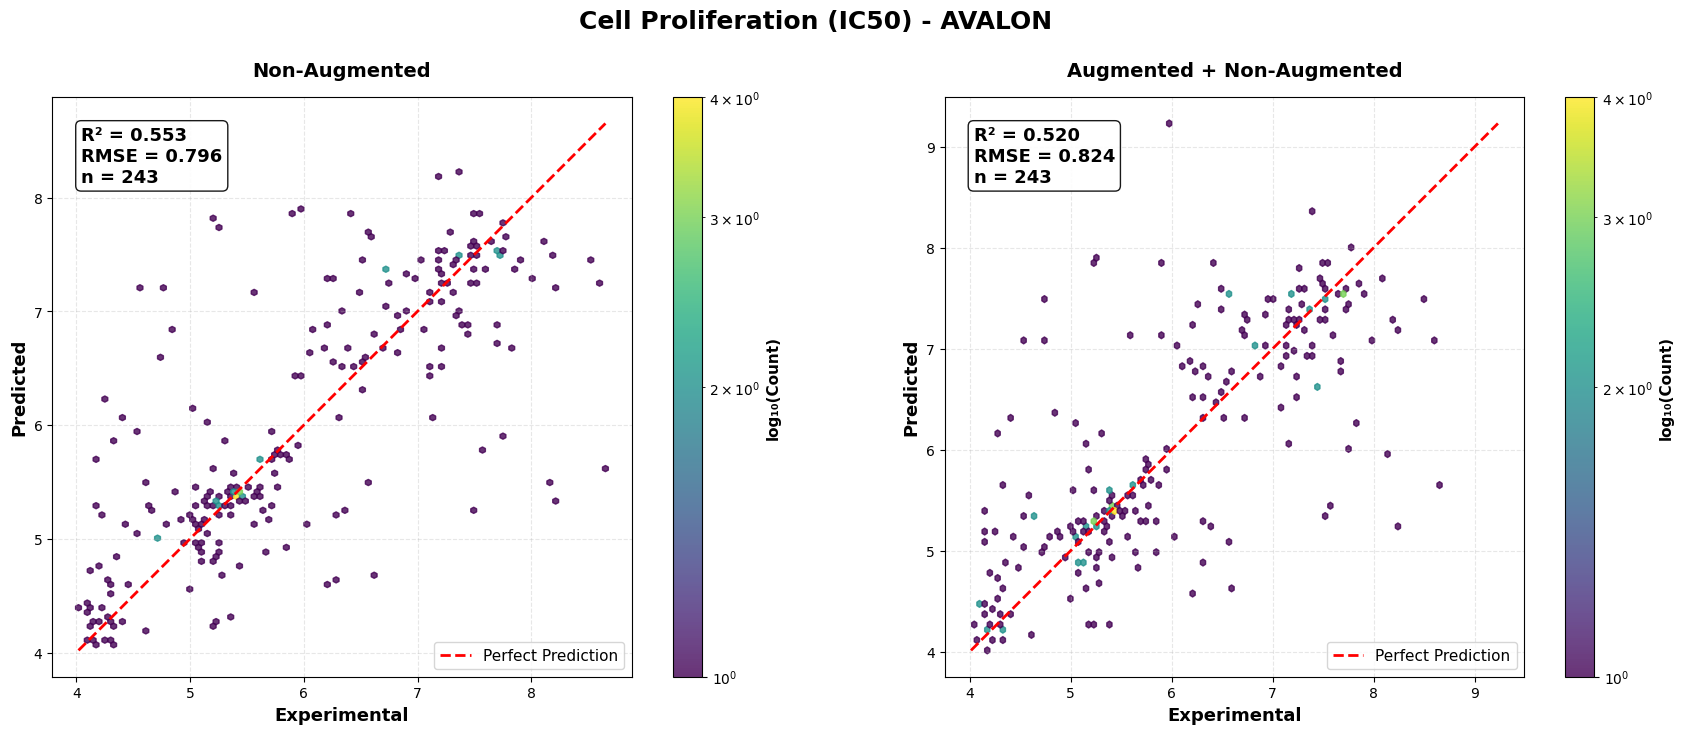

  ✓ Saved: Cell Proliferation (IC50)_rdkit2d_comparison.png


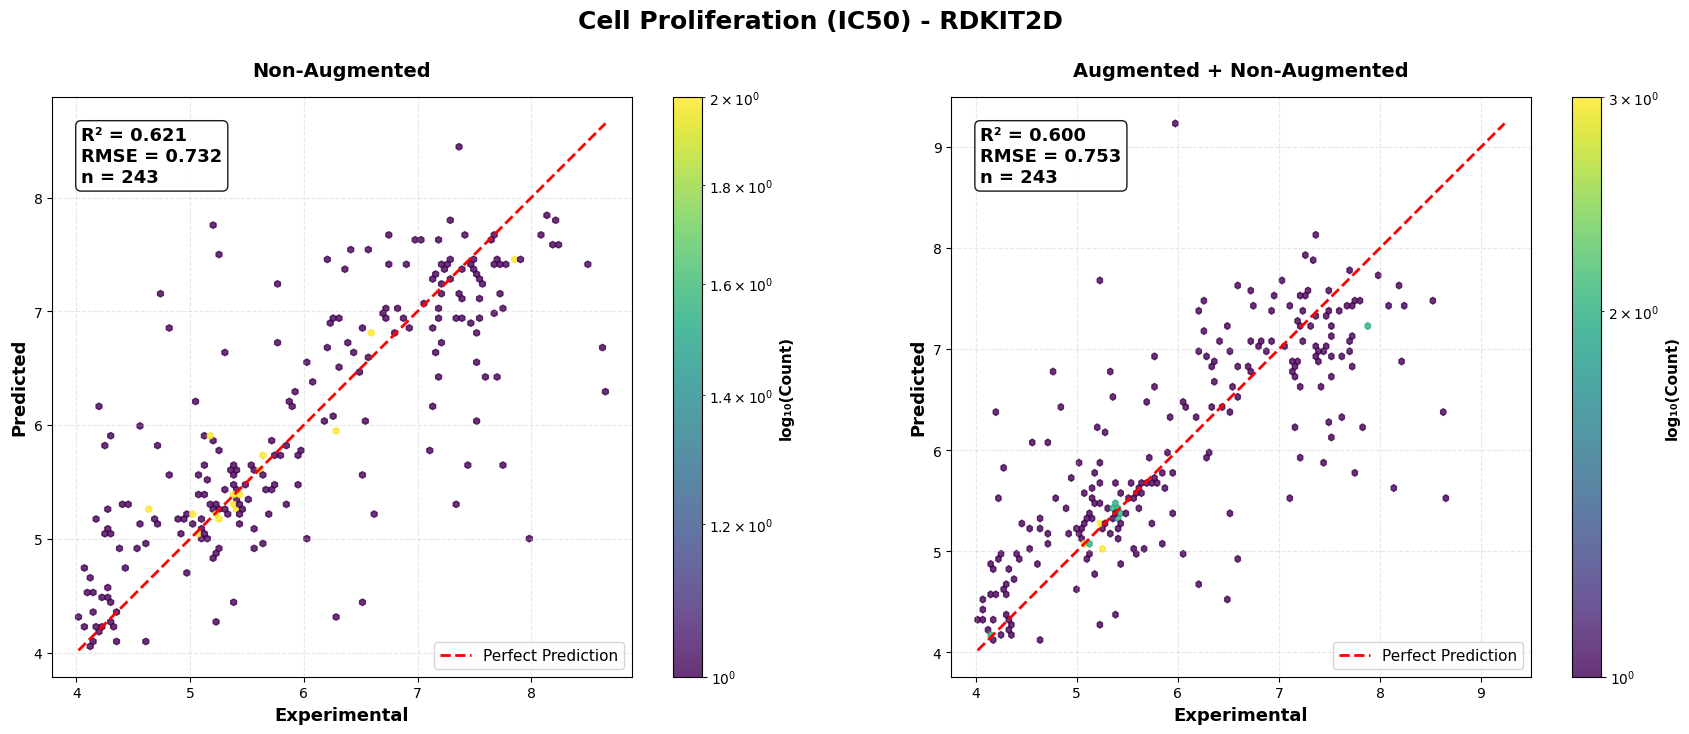

  ✓ Saved: Cell Proliferation (IC50)_ecfp6_comparison.png


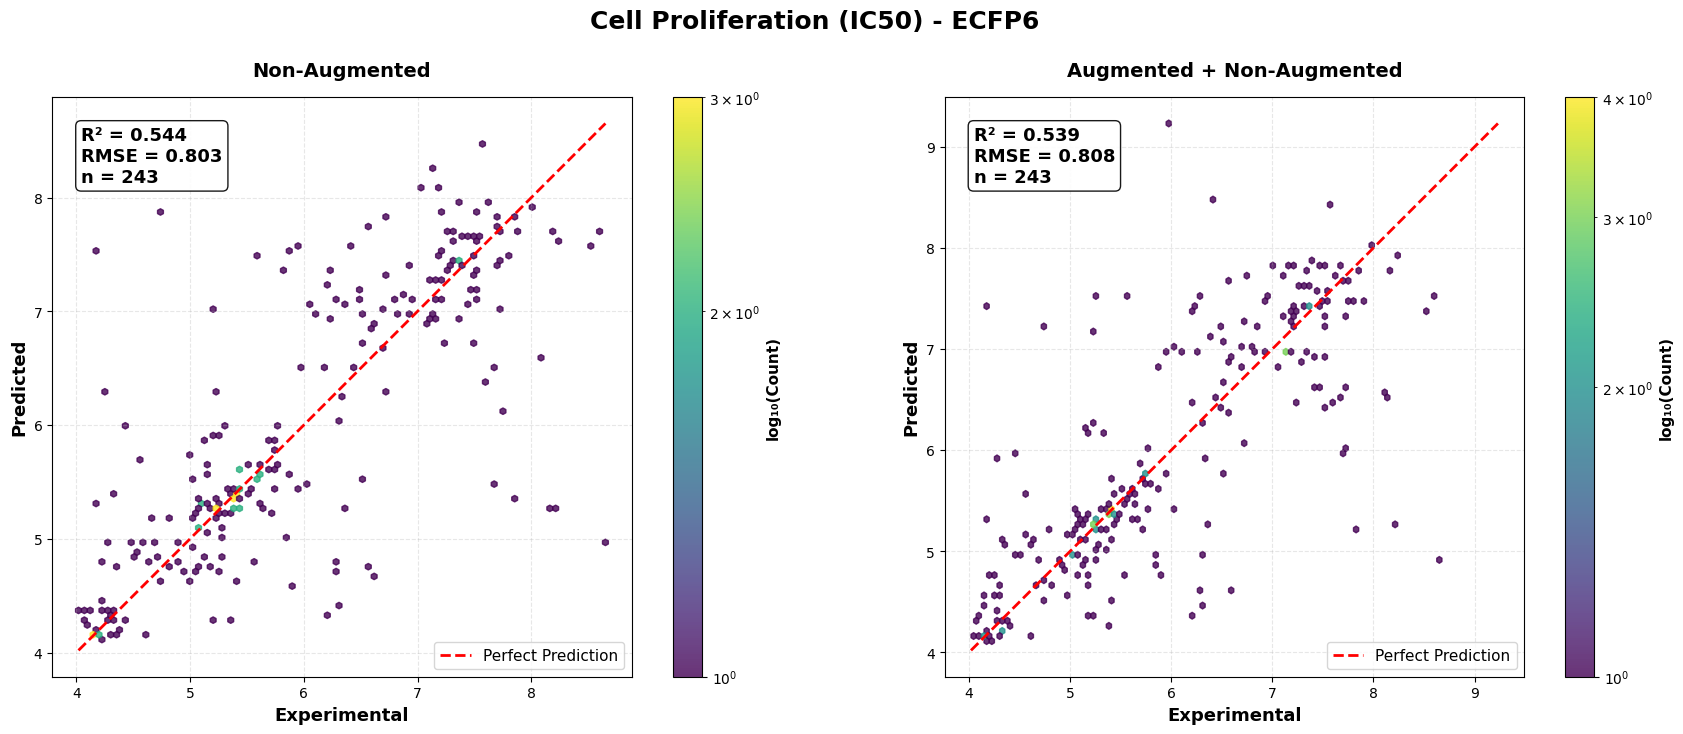


Processing: Clearance Microsomal (Mouse)
  ✓ Saved: Clearance Microsomal (Mouse)_avalon_comparison.png


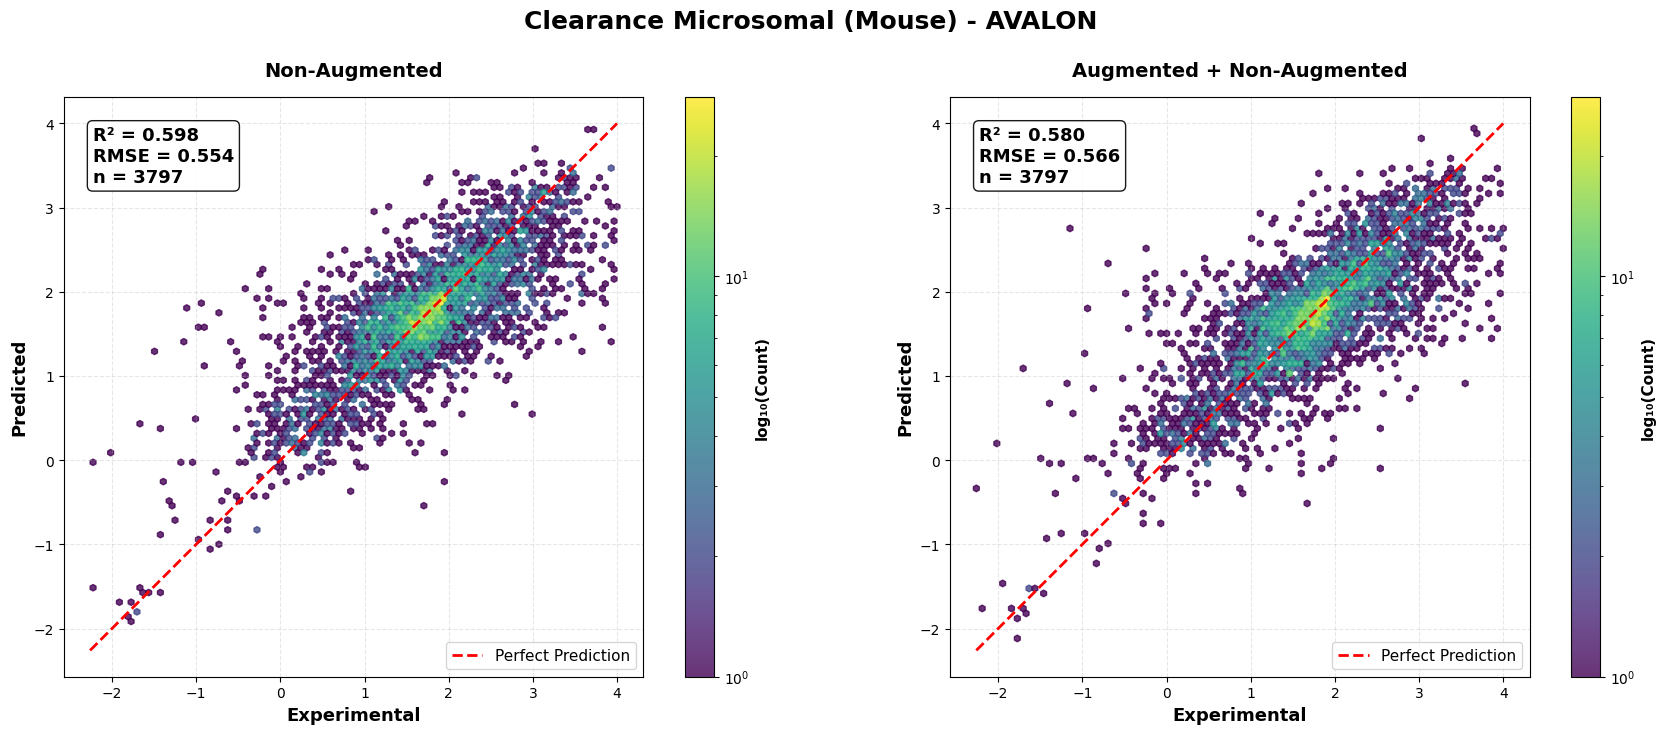

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: Clearance Microsomal (Rat)
  ✓ Saved: Clearance Microsomal (Rat)_avalon_comparison.png


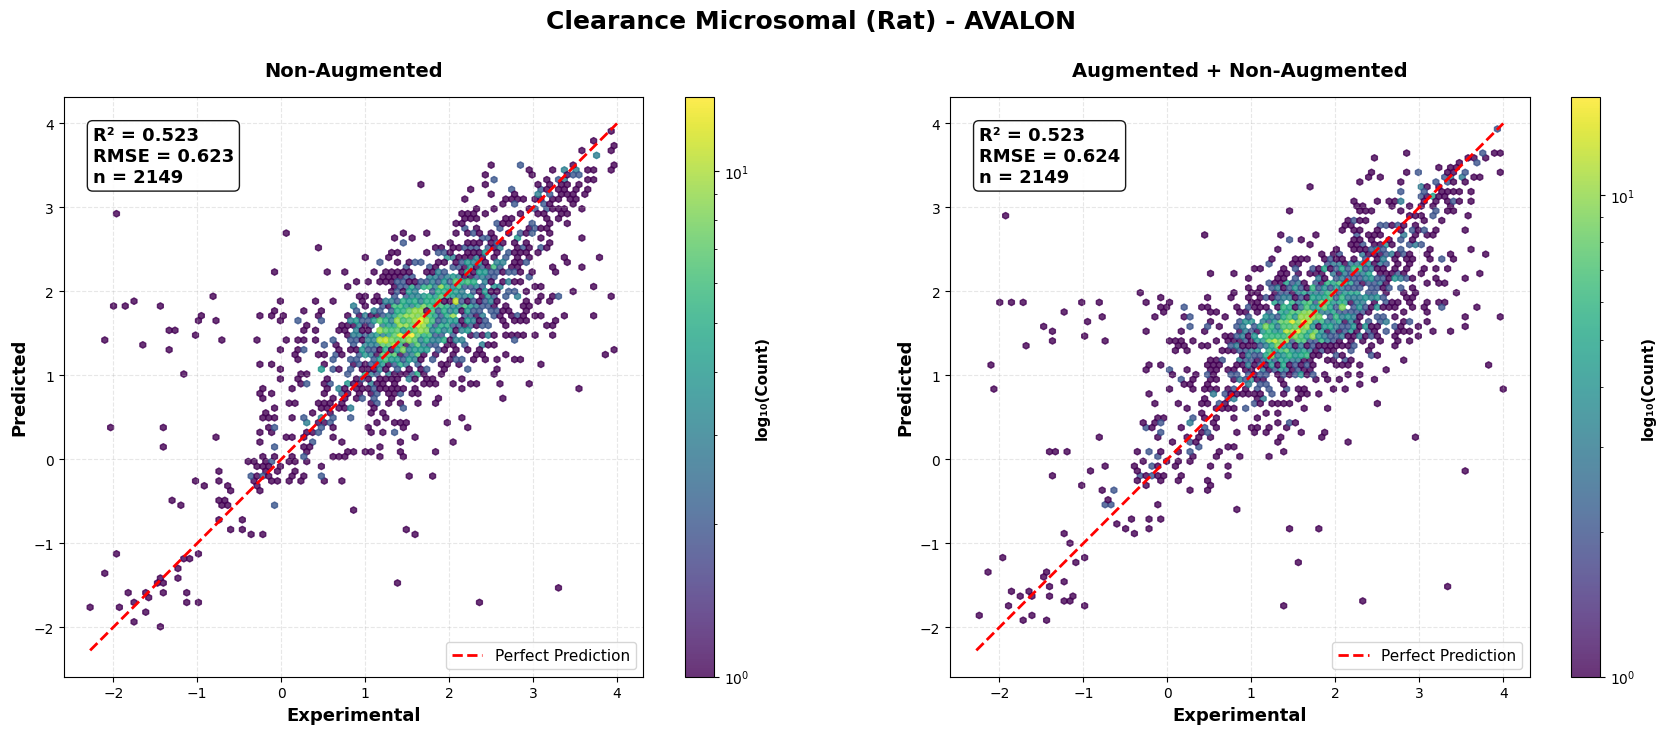

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: Clearance Renal
  ✓ Saved: Clearance Renal_avalon_comparison.png


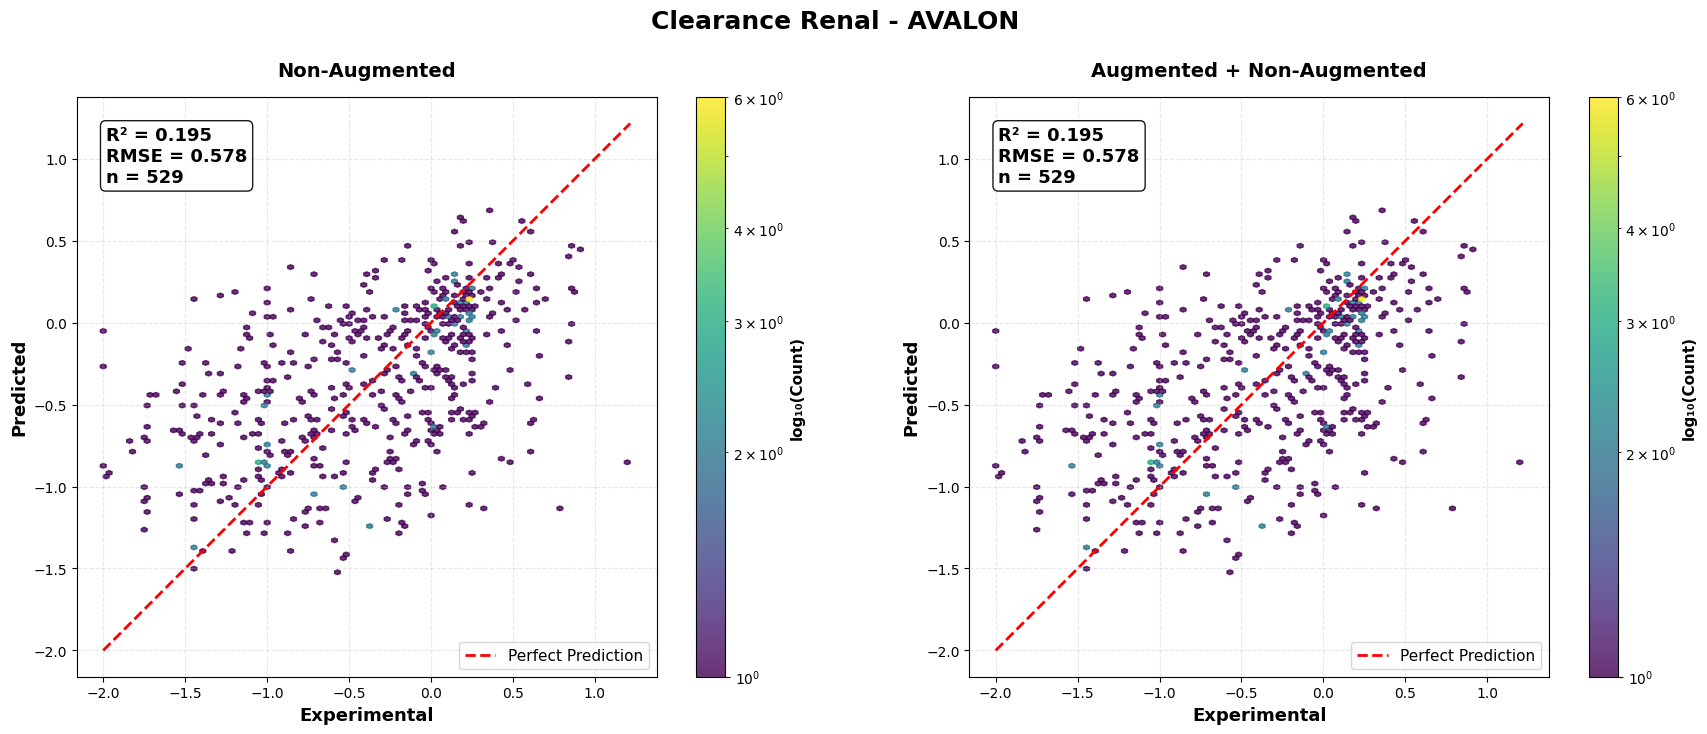

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: Clearance Total (Rat, iv)
  ✓ Saved: Clearance Total (Rat, iv)_avalon_comparison.png


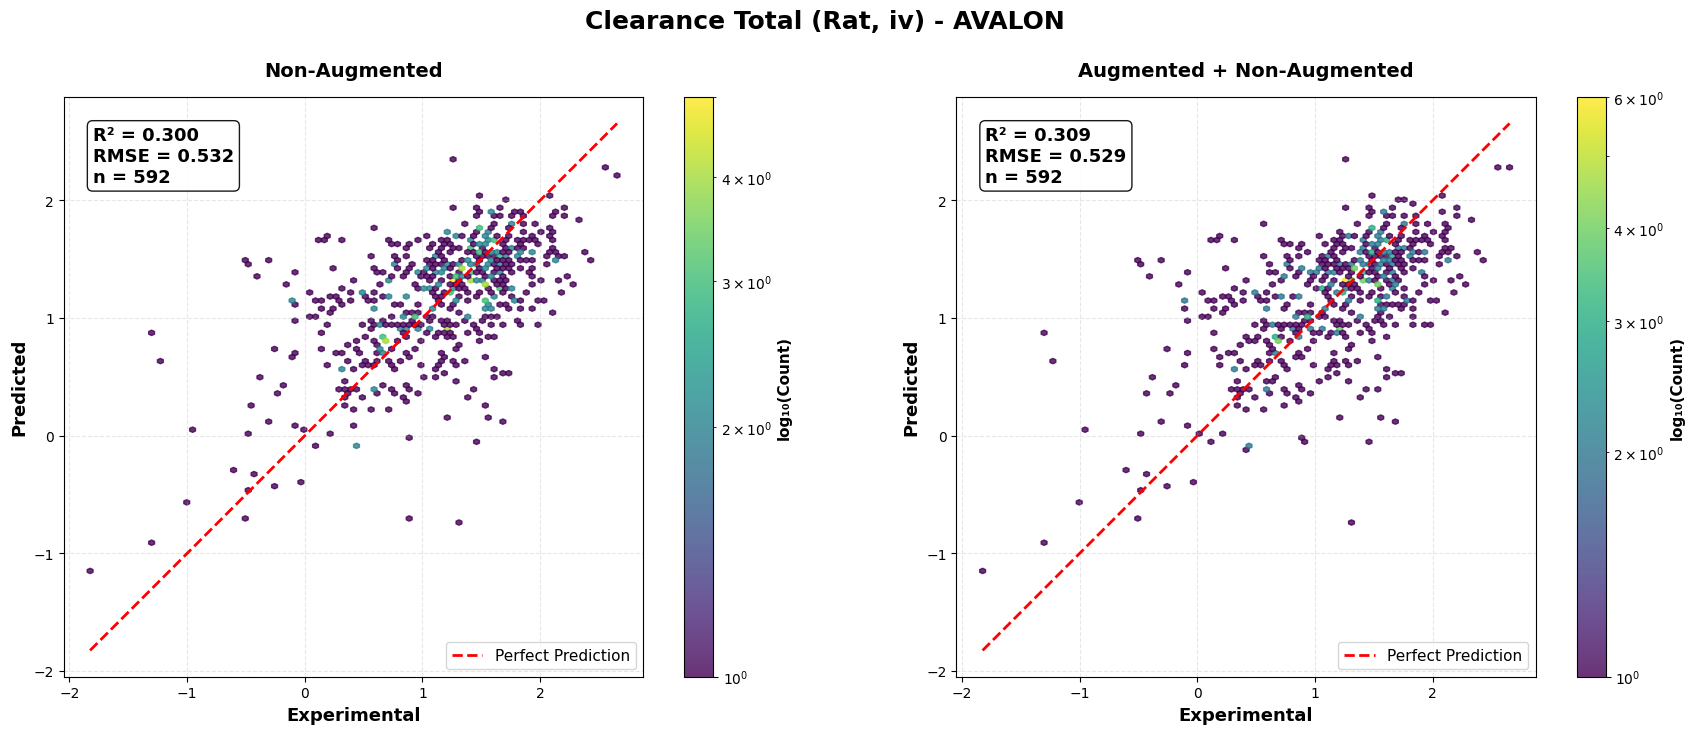

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: Efflux Ratio (Caco2)
  ✓ Saved: Efflux Ratio (Caco2)_avalon_comparison.png


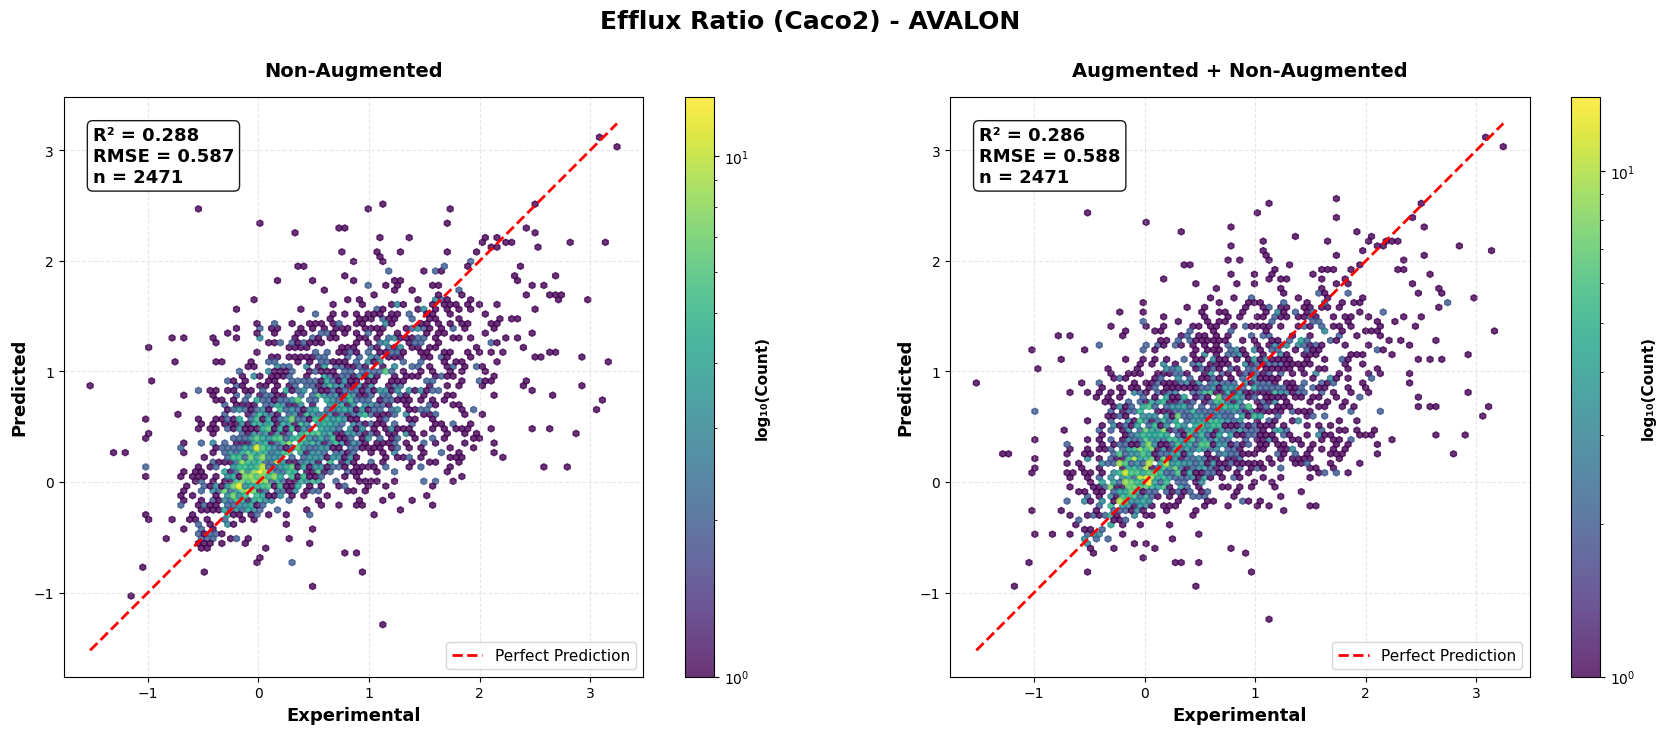

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: Efflux Ratio (MDCK-MDR1)
  ✓ Saved: Efflux Ratio (MDCK-MDR1)_avalon_comparison.png


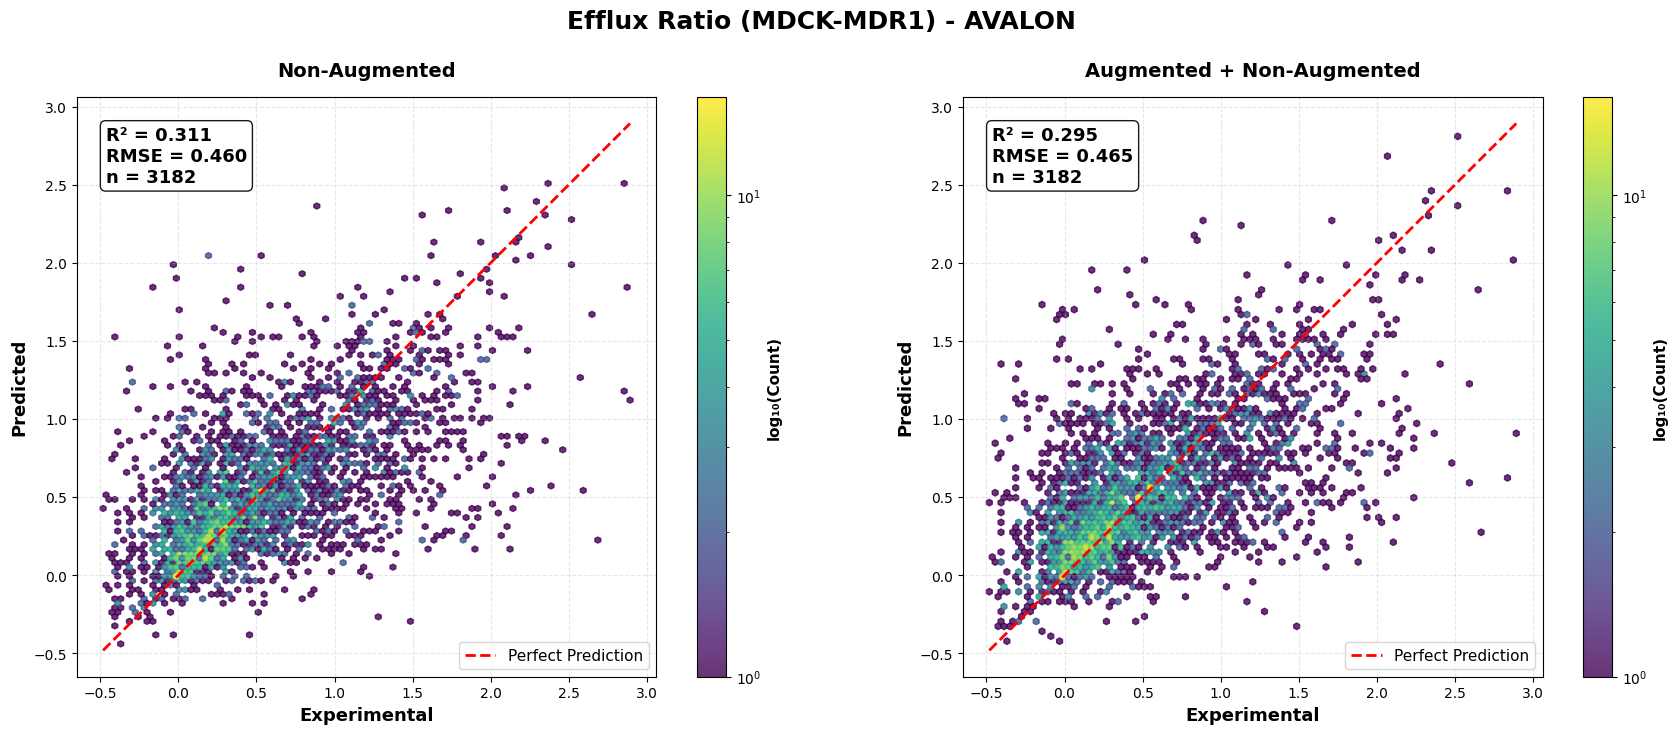

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: GI50 (Tumor)
  ✓ Saved: GI50 (Tumor)_avalon_comparison.png


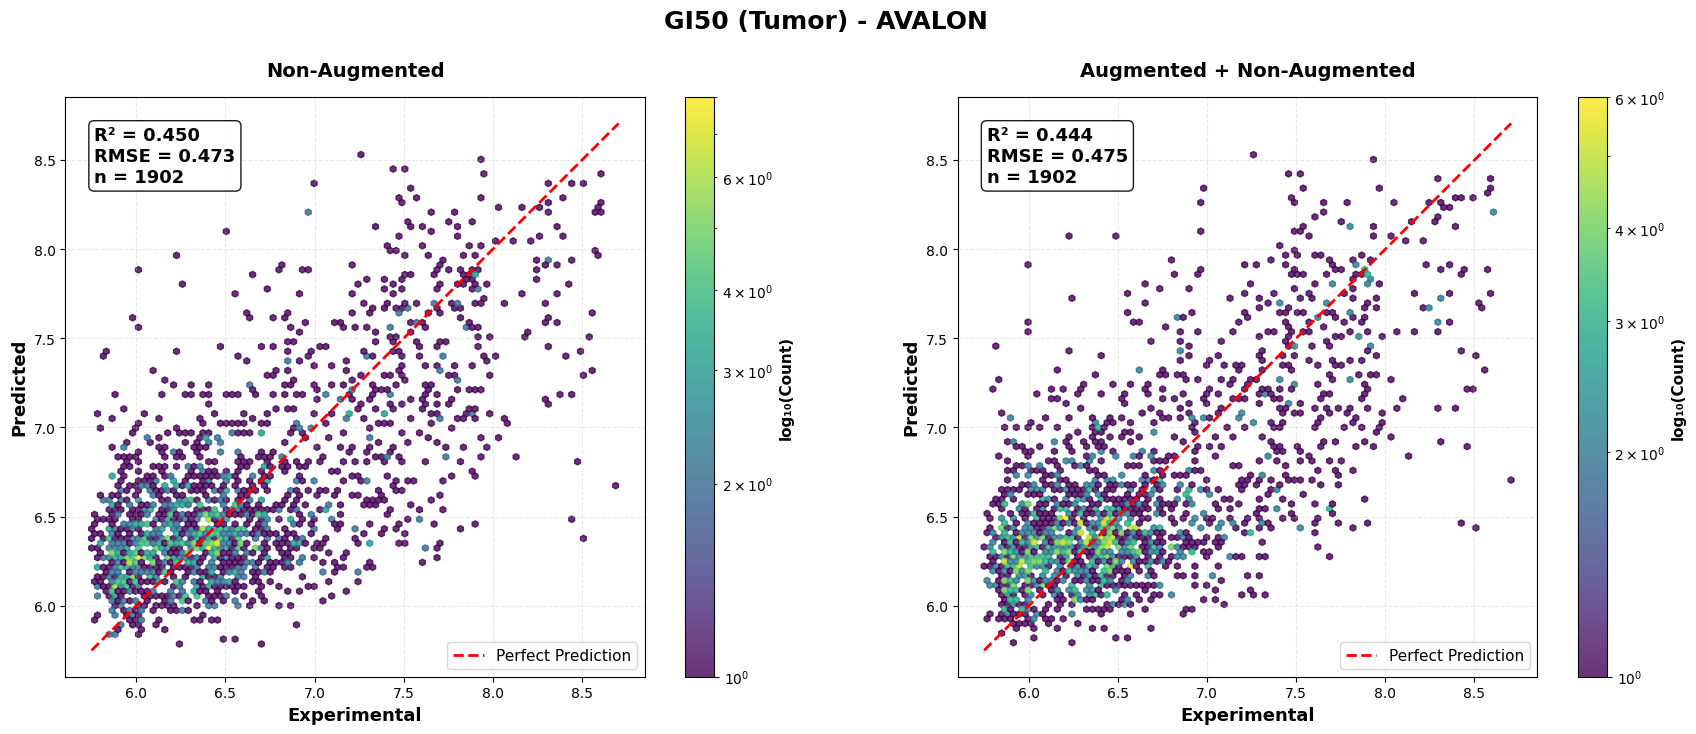

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: HFE
  ✓ Saved: HFE_avalon_comparison.png


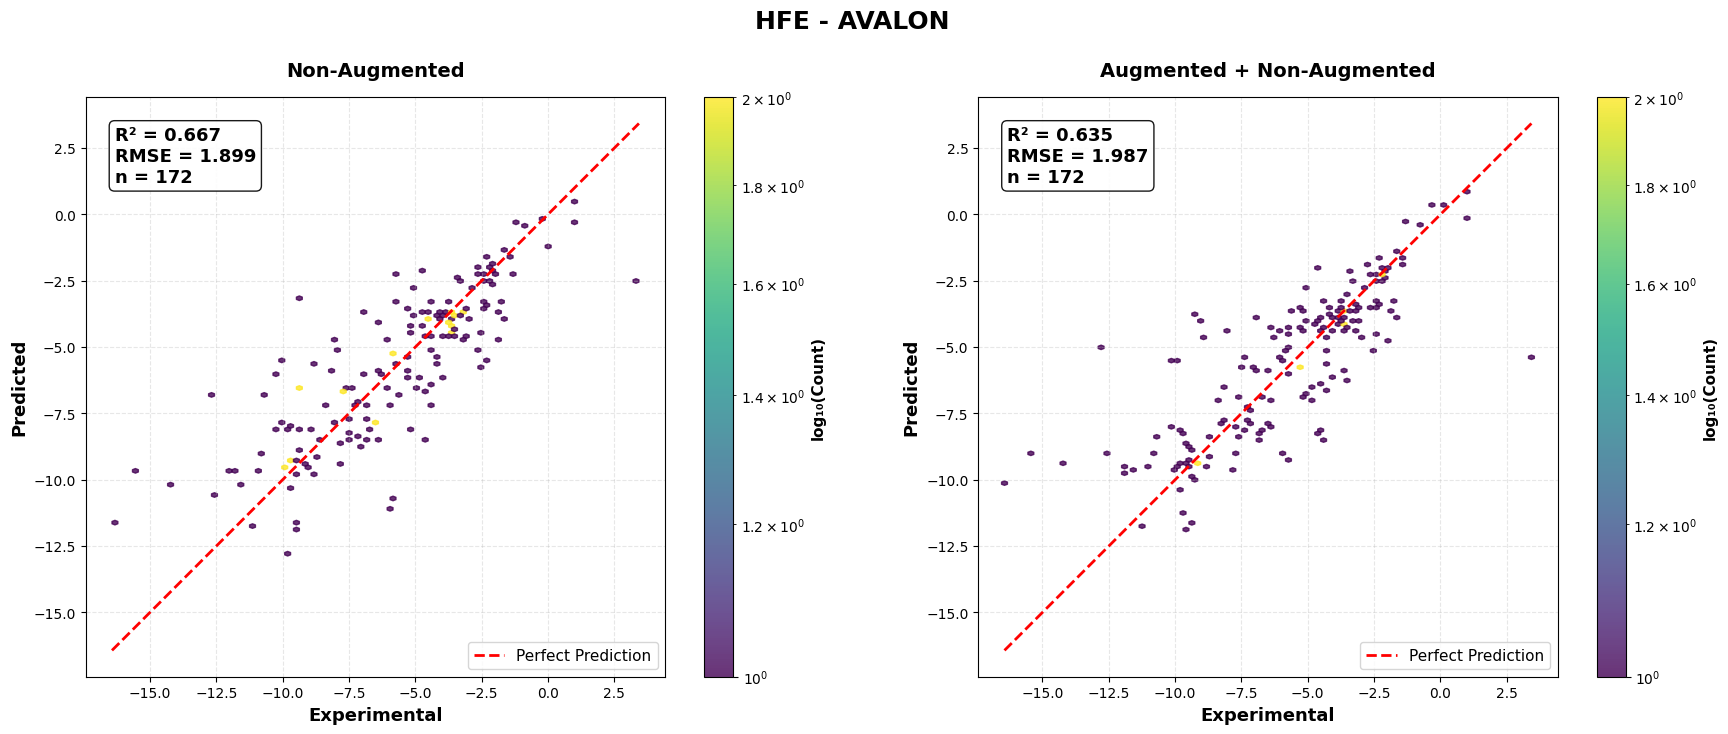

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: Half Life (Human, Microsome)
  ✓ Saved: Half Life (Human, Microsome)_avalon_comparison.png


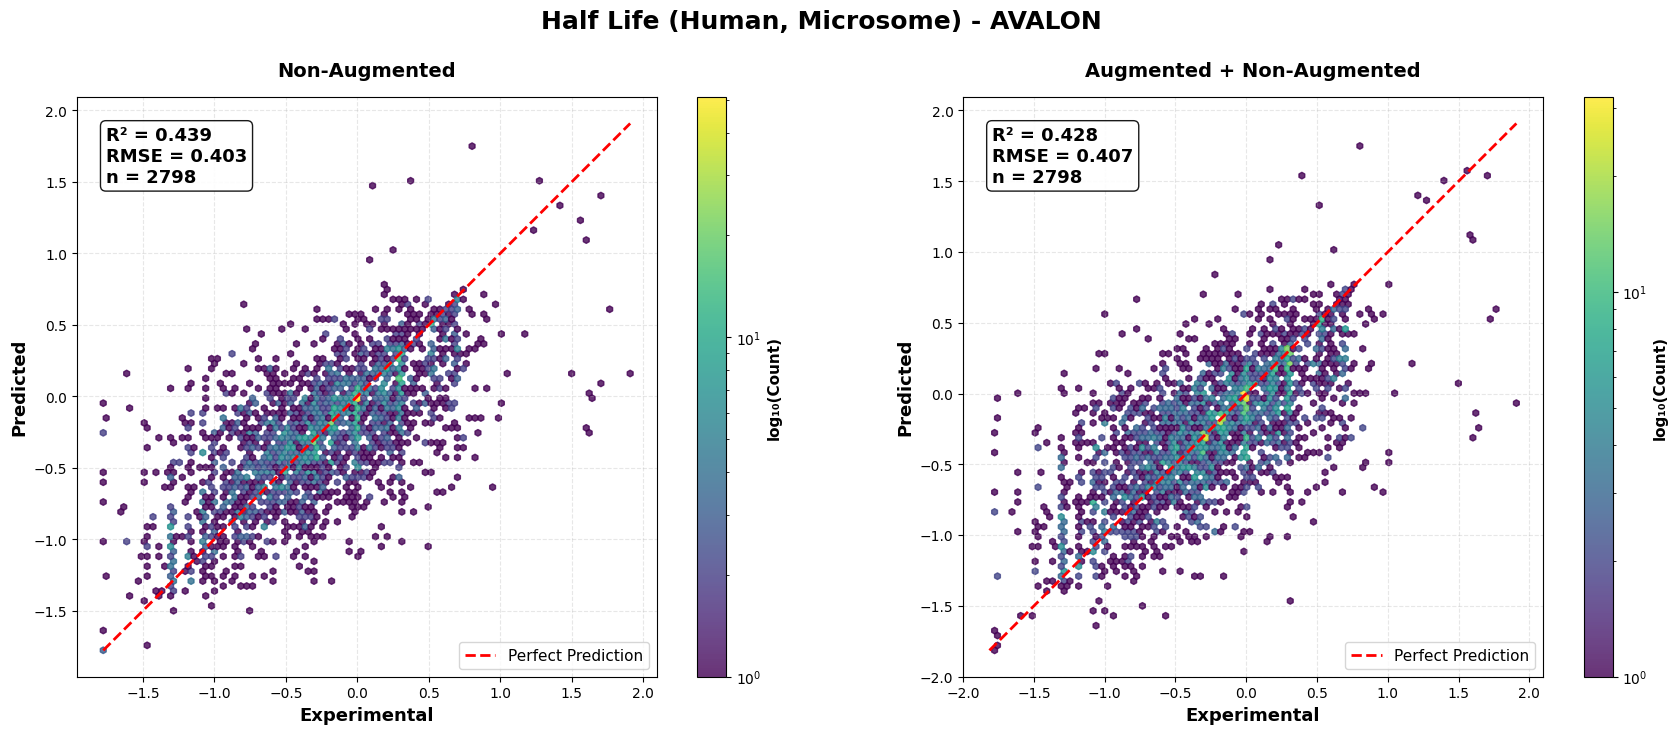

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: Half Life (Human, Plasma)
  ✓ Saved: Half Life (Human, Plasma)_avalon_comparison.png


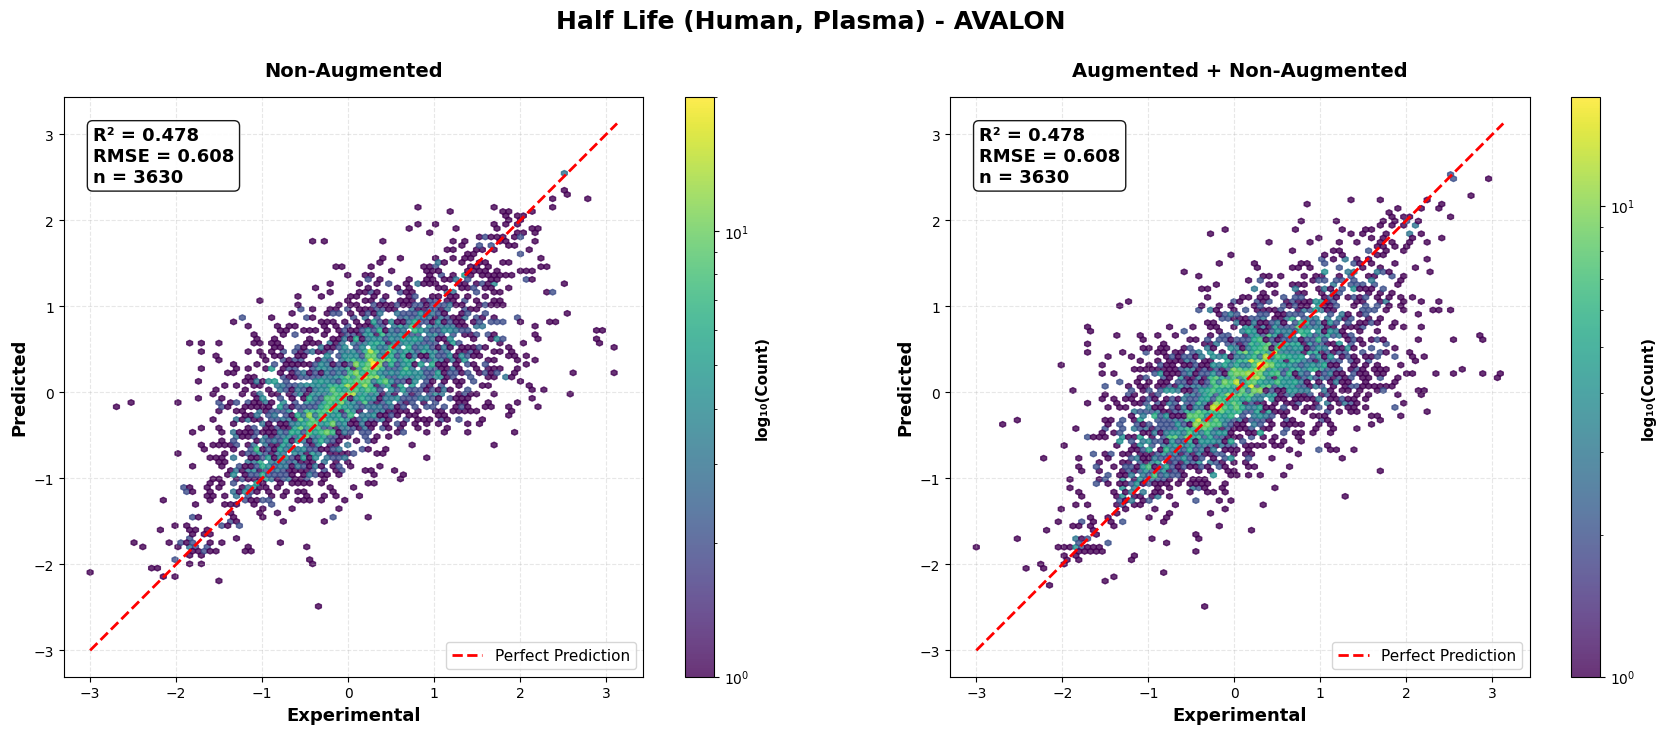

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: Half Life (Rat, Microsome)
  ✓ Saved: Half Life (Rat, Microsome)_avalon_comparison.png


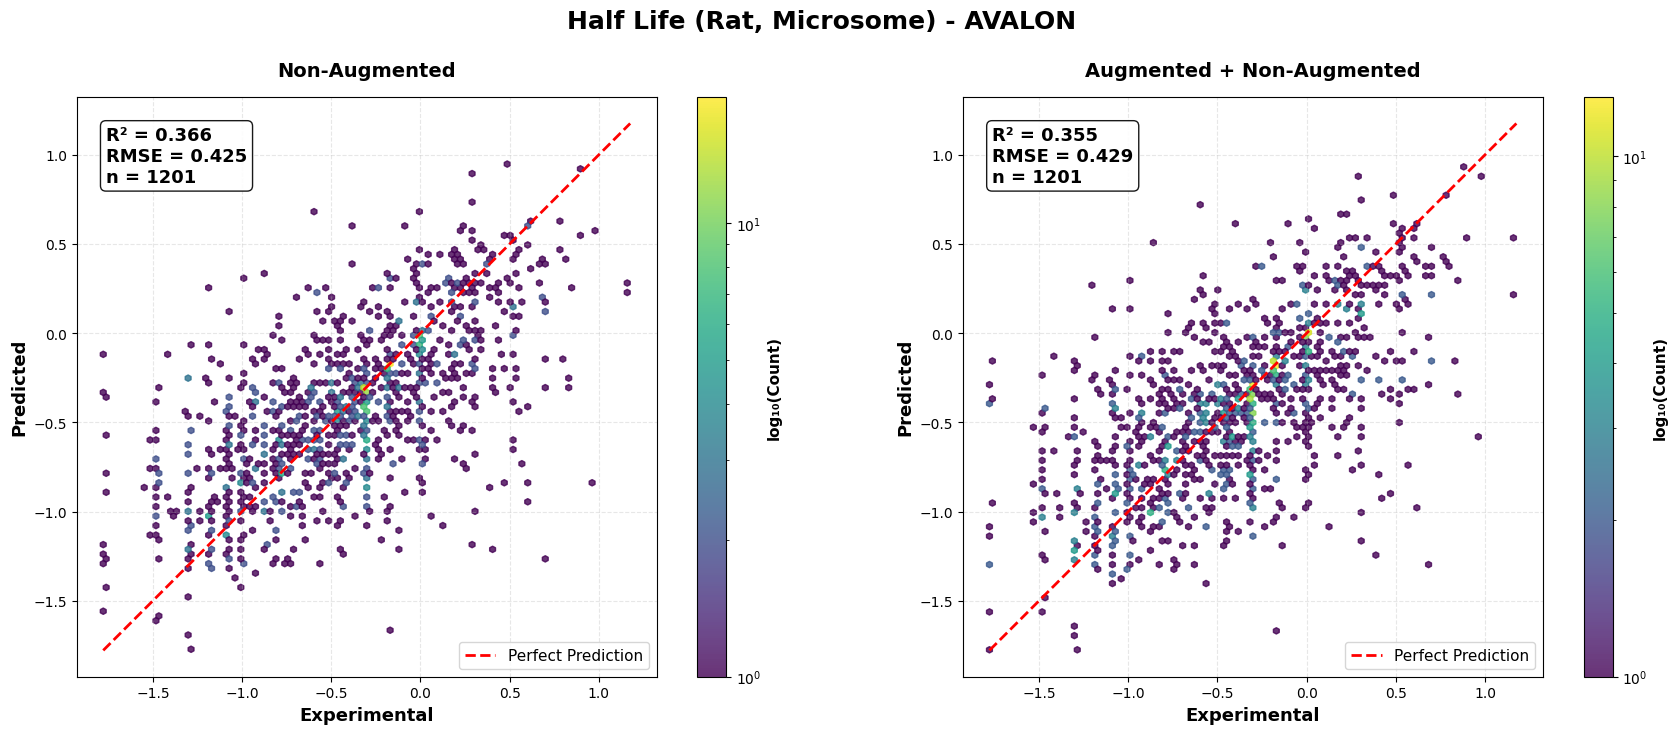

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

Processing: Half Life (Rat, Plasma)
  ✓ Saved: Half Life (Rat, Plasma)_avalon_comparison.png


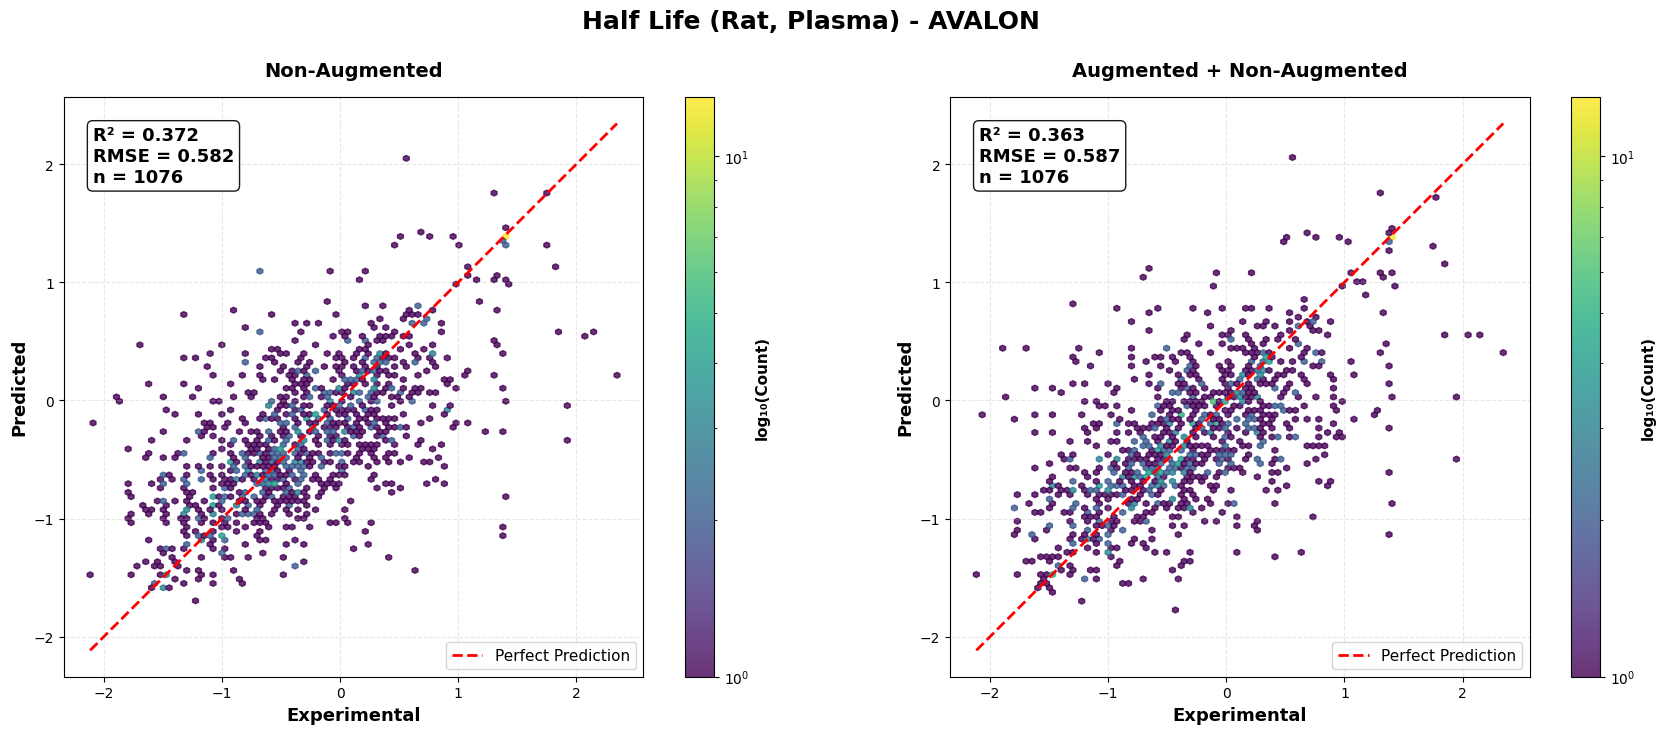

  Missing predictions for rdkit2d
  Missing predictions for ecfp6

All comparison plots completed!
Plots saved in: ../data/performance/*/plots_comparison/


In [2]:
plot_comparison_pred_vs_exp(
    output_dir='../data/performance',
    figsize=(18, 7),
    save_plots=True,
    plot_format='png',
    dpi=300
)

# UMAP vizualisation

In [17]:

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import os

# ============================================================================
# DATA LOADING AND PREPROCESSING FUNCTIONS
# ============================================================================

def load_data(filepath):
    """Load the data from CSV or Parquet file"""
    if filepath.endswith('.parquet'):
        df = pd.read_parquet(filepath)
    elif filepath.endswith('.csv'):
        df = pd.read_csv(filepath)
    else:
        raise ValueError("File must be either .csv or .parquet format")
    
    print(f"Loaded data with shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    return df

def detect_experimental_column(df):
    """Automatically detect the experimental data column"""
    # Common patterns for experimental columns
    potential_exp_cols = []
    
    for col in df.columns:
        # Skip prediction columns
        if 'pred' in col.lower():
            continue
        # Skip SMILES column
        if col.lower() == 'smiles':
            continue
        # Skip UMAP columns if they exist
        if 'umap' in col.lower():
            continue
            
        # Check if column contains numeric data
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            # Check if it has actual values (not all NaN)
            if df[col].notna().sum() > 0:
                potential_exp_cols.append(col)
    
    if len(potential_exp_cols) == 0:
        raise ValueError("No experimental data column found")
    elif len(potential_exp_cols) == 1:
        exp_col = potential_exp_cols[0]
        print(f"Detected experimental column: '{exp_col}'")
        return exp_col
    else:
        # If multiple candidates, try to find the most likely one
        for col in potential_exp_cols:
            # Look for common keywords
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in ['hfe', 'exp', 'actual', 'true', 'measured', 'observed', 'efflux', 'ratio', 'activity', 'potency']):
                print(f"Detected experimental column: '{col}'")
                return col
        
        # If no clear match, use the first non-prediction numeric column
        exp_col = potential_exp_cols[0]
        print(f"Using first numeric column as experimental: '{exp_col}'")
        print(f"Other potential columns: {potential_exp_cols[1:]}")
        return exp_col

def identify_prediction_columns(df):
    """Identify augmented and non-augmented prediction columns"""
    non_aug_cols = [col for col in df.columns if 'pred' in col.lower() and 'non_aug' in col.lower() and 'aug_plus' not in col.lower()]
    aug_cols = [col for col in df.columns if 'pred' in col.lower() and 'aug_plus' in col.lower()]
    
    print(f"Found {len(non_aug_cols)} non-augmented columns")
    print(f"Found {len(aug_cols)} augmented columns")
    
    if len(non_aug_cols) == 0 and len(aug_cols) == 0:
        print("WARNING: No prediction columns found with expected naming pattern")
        all_pred_cols = [col for col in df.columns if 'pred' in col.lower()]
        print(f"All prediction-like columns: {all_pred_cols}")
    
    return non_aug_cols, aug_cols

# ============================================================================
# MOLECULAR FINGERPRINT FUNCTIONS
# ============================================================================

def compute_molecular_fingerprints(smiles_list, radius=3, nBits=2048):
    """Compute Morgan fingerprints from SMILES strings"""
    fingerprints = []
    valid_indices = []
    
    print(f"Computing fingerprints for {len(smiles_list)} molecules...")
    
    for idx, smiles in enumerate(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
                fingerprints.append(np.array(fp))
                valid_indices.append(idx)
        except Exception as e:
            print(f"Failed for SMILES at index {idx}: {e}")
            continue
    
    print(f"Successfully computed {len(fingerprints)} fingerprints")
    return np.array(fingerprints), valid_indices

def standardize_features(X):
    """Standardize features for UMAP"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"Standardized features with shape: {X_scaled.shape}")
    return X_scaled

# ============================================================================
# UMAP FUNCTIONS
# ============================================================================

def perform_umap(X_scaled, n_neighbors=15, min_dist=0.1, random_state=42):
    """Perform UMAP dimensionality reduction"""
    print("Performing UMAP...")
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=random_state
    )
    embeddings = reducer.fit_transform(X_scaled)
    print(f"UMAP complete. Embeddings shape: {embeddings.shape}")
    return embeddings

# ============================================================================
# PREDICTION AND ERROR CALCULATION FUNCTIONS
# ============================================================================

def calculate_mean_predictions(df, pred_cols):
    """Calculate mean predictions across folds"""
    if not pred_cols:
        return pd.Series([np.nan] * len(df))
    
    valid_preds = df[pred_cols].replace([np.inf, -np.inf], np.nan)
    valid_preds = valid_preds.dropna(axis=1, how='all')
    
    if valid_preds.empty:
        return pd.Series([np.nan] * len(df))
    
    mean_pred = valid_preds.mean(axis=1)
    return mean_pred

def calculate_absolute_errors(df, pred_cols, exp_col):
    """Calculate absolute errors between experimental and predicted values"""
    mean_pred = calculate_mean_predictions(df, pred_cols)
    abs_error = np.abs(df[exp_col] - mean_pred)
    return mean_pred, abs_error

def add_predictions_and_errors(df, non_aug_cols, aug_cols, exp_col):
    """Add prediction and error columns to dataframe"""
    # Non-augmented
    if non_aug_cols:
        df['pred_non_aug'], df['abs_error_non_aug'] = calculate_absolute_errors(df, non_aug_cols, exp_col)
    else:
        df['pred_non_aug'] = np.nan
        df['abs_error_non_aug'] = np.nan
    
    # Augmented
    if aug_cols:
        df['pred_aug'], df['abs_error_aug'] = calculate_absolute_errors(df, aug_cols, exp_col)
    else:
        df['pred_aug'] = np.nan
        df['abs_error_aug'] = np.nan
    
    # Statistics
    print("\n=== Prediction Statistics ===")
    print(f"Experimental column: '{exp_col}'")
    print(f"Non-aug - Valid predictions: {df['pred_non_aug'].notna().sum()}")
    print(f"Aug - Valid predictions: {df['pred_aug'].notna().sum()}")
    
    return df

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_absolute_errors_comparison(df, exp_col, figsize=(16, 7)):
    """Plot side-by-side UMAP with absolute errors for augmented and non-augmented"""
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Non-augmented
    mask1 = ~np.isnan(df['abs_error_non_aug'])
    if mask1.sum() > 0:
        scatter1 = axes[0].scatter(
            df.loc[mask1, 'UMAP1'], 
            df.loc[mask1, 'UMAP2'],
            c=df.loc[mask1, 'abs_error_non_aug'],
            cmap='Spectral_r',
            s=30,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )
        axes[0].set_title('Non-Augmented Model - Absolute Error', fontsize=14, fontweight='bold')
        plt.colorbar(scatter1, ax=axes[0], label='Absolute Error')
    else:
        axes[0].text(0.5, 0.5, 'No non-augmented predictions', ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Non-Augmented Model - No Data', fontsize=14)
    
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    
    # Augmented
    mask2 = ~np.isnan(df['abs_error_aug'])
    if mask2.sum() > 0:
        scatter2 = axes[1].scatter(
            df.loc[mask2, 'UMAP1'],
            df.loc[mask2, 'UMAP2'],
            c=df.loc[mask2, 'abs_error_aug'],
            cmap='Spectral_r',
            s=30,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )
        axes[1].set_title('Augmented Model - Absolute Error', fontsize=14, fontweight='bold')
        plt.colorbar(scatter2, ax=axes[1], label='Absolute Error')
    else:
        axes[1].text(0.5, 0.5, 'No augmented predictions', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Augmented Model - No Data', fontsize=14)
    
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    
    plt.suptitle(f'UMAP - Absolute Prediction Errors Comparison\n({exp_col})', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

def plot_predictions_comparison(df, exp_col, figsize=(20, 7)):
    """Plot side-by-side predictions and experimental values"""
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Experimental values
    mask_exp = ~np.isnan(df[exp_col])
    if mask_exp.sum() > 0:
        scatter1 = axes[0].scatter(
            df.loc[mask_exp, 'UMAP1'],
            df.loc[mask_exp, 'UMAP2'],
            c=df.loc[mask_exp, exp_col],
            cmap='viridis',
            s=30,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )
        axes[0].set_title(f'Experimental {exp_col}', fontsize=14, fontweight='bold')
        plt.colorbar(scatter1, ax=axes[0], label=exp_col)
    else:
        axes[0].text(0.5, 0.5, 'No experimental data', ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Experimental - No Data', fontsize=14)
    
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    
    # Non-augmented predictions
    mask_non_aug = ~np.isnan(df['pred_non_aug'])
    if mask_non_aug.sum() > 0:
        scatter2 = axes[1].scatter(
            df.loc[mask_non_aug, 'UMAP1'],
            df.loc[mask_non_aug, 'UMAP2'],
            c=df.loc[mask_non_aug, 'pred_non_aug'],
            cmap='viridis',
            s=30,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )
        axes[1].set_title('Non-Augmented Predictions', fontsize=14, fontweight='bold')
        plt.colorbar(scatter2, ax=axes[1], label=f'{exp_col} (Predicted)')
    else:
        axes[1].text(0.5, 0.5, 'No predictions', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Non-Augmented - No Data', fontsize=14)
    
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    
    # Augmented predictions
    mask_aug = ~np.isnan(df['pred_aug'])
    if mask_aug.sum() > 0:
        scatter3 = axes[2].scatter(
            df.loc[mask_aug, 'UMAP1'],
            df.loc[mask_aug, 'UMAP2'],
            c=df.loc[mask_aug, 'pred_aug'],
            cmap='viridis',
            s=30,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5
        )
        axes[2].set_title('Augmented Predictions', fontsize=14, fontweight='bold')
        plt.colorbar(scatter3, ax=axes[2], label=f'{exp_col} (Predicted)')
    else:
        axes[2].text(0.5, 0.5, 'No predictions', ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title('Augmented - No Data', fontsize=14)
    
    axes[2].set_xlabel('UMAP 1')
    axes[2].set_ylabel('UMAP 2')
    
    plt.suptitle(f'UMAP - Experimental vs Predicted Values ({exp_col})', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

def plot_hexbin_errors(df, exp_col, gridsize=60, figsize=(16, 7)):
    """Create hexbin plots for absolute errors"""
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Non-augmented hexbin
    mask1 = ~np.isnan(df['abs_error_non_aug'])
    if mask1.sum() > 0:
        hexbin1 = axes[0].hexbin(
            df.loc[mask1, 'UMAP1'],
            df.loc[mask1, 'UMAP2'],
            C=df.loc[mask1, 'abs_error_non_aug'],
            gridsize=gridsize,
            cmap='Spectral_r',
            reduce_C_function=np.mean,
            mincnt=1
        )
        axes[0].set_title('Non-Augmented Model - Mean Absolute Error (Hexbin)', fontsize=14, fontweight='bold')
        plt.colorbar(hexbin1, ax=axes[0], label='Mean Absolute Error')
    else:
        axes[0].text(0.5, 0.5, 'No non-augmented predictions', ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Non-Augmented Model - No Data', fontsize=14)
    
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    
    # Augmented hexbin
    mask2 = ~np.isnan(df['abs_error_aug'])
    if mask2.sum() > 0:
        hexbin2 = axes[1].hexbin(
            df.loc[mask2, 'UMAP1'],
            df.loc[mask2, 'UMAP2'],
            C=df.loc[mask2, 'abs_error_aug'],
            gridsize=gridsize,
            cmap='Spectral_r',
            reduce_C_function=np.mean,
            mincnt=1
        )
        axes[1].set_title('Augmented Model - Mean Absolute Error (Hexbin)', fontsize=14, fontweight='bold')
        plt.colorbar(hexbin2, ax=axes[1], label='Mean Absolute Error')
    else:
        axes[1].text(0.5, 0.5, 'No augmented predictions', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Augmented Model - No Data', fontsize=14)
    
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    
    plt.suptitle(f'UMAP Hexbin - Absolute Errors Comparison ({exp_col})', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

def plot_error_difference(df, exp_col, figsize=(10, 8)):
    """Plot the difference in errors between augmented and non-augmented"""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Calculate error difference
    error_diff = df['abs_error_aug'] - df['abs_error_non_aug']
    
    mask = ~np.isnan(error_diff)
    if mask.sum() > 0:
        # Calculate percentile for color scale limits
        valid_diff = error_diff[mask]
        vmin = -np.percentile(np.abs(valid_diff), 95)
        vmax = np.percentile(np.abs(valid_diff), 95)
        
        scatter = ax.scatter(
            df.loc[mask, 'UMAP1'],
            df.loc[mask, 'UMAP2'],
            c=error_diff[mask],
            cmap='RdBu_r',
            s=30,
            alpha=0.6,
            edgecolors='black',
            linewidth=0.5,
            vmin=vmin,
            vmax=vmax
        )
        
        ax.set_title(f'Error Difference (Augmented - Non-Augmented)\nBlue: Aug better | Red: Non-Aug better\n({exp_col})', 
                     fontsize=14, fontweight='bold')
        plt.colorbar(scatter, ax=ax, label='Error Difference')
    else:
        ax.text(0.5, 0.5, 'Cannot compare - missing predictions', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Error Difference - No Data', fontsize=14)
    
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    
    plt.tight_layout()
    return fig

def print_statistics(df, exp_col):
    """Print comprehensive statistics"""
    print("\n" + "="*60)
    print("COMPREHENSIVE ERROR STATISTICS")
    print(f"Experimental Column: {exp_col}")
    print("="*60)
    
    # Non-augmented statistics
    non_aug_valid = df['abs_error_non_aug'].notna().sum()
    if non_aug_valid > 0:
        print("\n--- Non-Augmented Model ---")
        print(f"Valid predictions: {non_aug_valid}")
        print(f"Mean Absolute Error: {df['abs_error_non_aug'].mean():.3f}")
        print(f"Median Absolute Error: {df['abs_error_non_aug'].median():.3f}")
        print(f"Std Dev: {df['abs_error_non_aug'].std():.3f}")
        print(f"Min Error: {df['abs_error_non_aug'].min():.3f}")
        print(f"Max Error: {df['abs_error_non_aug'].max():.3f}")
    else:
        print("\n--- Non-Augmented Model ---")
        print("No valid predictions available")
    
    # Augmented statistics
    aug_valid = df['abs_error_aug'].notna().sum()
    if aug_valid > 0:
        print("\n--- Augmented Model ---")
        print(f"Valid predictions: {aug_valid}")
        print(f"Mean Absolute Error: {df['abs_error_aug'].mean():.3f}")
        print(f"Median Absolute Error: {df['abs_error_aug'].median():.3f}")
        print(f"Std Dev: {df['abs_error_aug'].std():.3f}")
        print(f"Min Error: {df['abs_error_aug'].min():.3f}")
        print(f"Max Error: {df['abs_error_aug'].max():.3f}")
    else:
        print("\n--- Augmented Model ---")
        print("No valid predictions available")
    
    # Model comparison
    if non_aug_valid > 0 and aug_valid > 0:
        print("\n--- Model Comparison ---")
        error_diff = df['abs_error_aug'] - df['abs_error_non_aug']
        valid_comparison = error_diff.notna().sum()
        print(f"Compounds with both predictions: {valid_comparison}")
        if valid_comparison > 0:
            print(f"Mean Error Difference (Aug - NonAug): {error_diff.mean():.3f}")
            print(f"Compounds where Aug is better: {(error_diff < 0).sum()}")
            print(f"Compounds where NonAug is better: {(error_diff > 0).sum()}")
            print(f"Compounds with equal performance: {(error_diff == 0).sum()}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_mae_vs_experimental_bins(df, exp_col, bin_width=0.2, figsize=(10, 6)):
    """
    Plot Mean Absolute Error (MAE) vs Experimental Value Bins,
    and show compound count per bin as a bar plot.

    Args:
        df (pd.DataFrame): DataFrame containing predictions and errors.
        exp_col (str): Name of the experimental data column.
        bin_width (float): Width of the bins for experimental values.
        figsize (tuple): Size of the figure.
    """
    # Ensure valid experimental and error values
    df_valid = df[[exp_col, 'abs_error_non_aug', 'abs_error_aug']].dropna()

    # Create bins
    min_val = df_valid[exp_col].min()
    max_val = df_valid[exp_col].max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)
    bin_labels = (bins[:-1] + bins[1:]) / 2  # Midpoint of bins

    df_valid['exp_bin'] = pd.cut(df_valid[exp_col], bins=bins, labels=bin_labels, include_lowest=True)

    # Group by bins and calculate median MAE
    grouped = df_valid.groupby('exp_bin').agg({
        'abs_error_non_aug': 'median',
        'abs_error_aug': 'median'
    }).reset_index()

    # Count of compounds per bin
    bin_counts = df_valid['exp_bin'].value_counts().sort_index()

    # Plot
    fig, ax1 = plt.subplots(figsize=figsize)

    # Line plots for MAE
    ax1.plot(grouped['exp_bin'], grouped['abs_error_non_aug'], label='Non-Augmented', marker='o', color='green')
    ax1.plot(grouped['exp_bin'], grouped['abs_error_aug'], label='Augmented', marker='o', color='orange')
    ax1.set_xlabel(f'Experimental {exp_col} (Binned)')
    ax1.set_ylabel('Median Absolute Error')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Bar plot for compound counts on secondary y-axis
    ax2 = ax1.twinx()
    ax2.bar(bin_counts.index.astype(float), bin_counts.values, 
            width=bin_width * 0.9, alpha=0.3, color='gray', label='Compound Count')
    ax2.set_ylabel('Number of Compounds')

    # Optional: Add compound count legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title(f'Median Absolute Error vs Experimental {exp_col} (Bin Width = {bin_width})')
    plt.tight_layout()
    plt.show()


In [11]:
dict_col_to_df = {}


for exp_col in os.listdir("../data/performance/"):
    if len(os.listdir(f"../data/performance/{exp_col}"))>0:
        df = load_data(f"../data/performance/{exp_col}/{exp_col}_predictions.parquet")
        # Step 2: Detect experimental column if not provided
        if exp_col is None:
            exp_col = detect_experimental_column(df)
        else:
            print(f"Using specified experimental column: '{exp_col}'")
        # Step 3: Identify prediction columns
        non_aug_cols, aug_cols = identify_prediction_columns(df)
        # Step 4: Compute molecular fingerprints
        X_fingerprints, valid_indices = compute_molecular_fingerprints(df['SMILES'].values)
        df_valid = df.iloc[valid_indices].copy().reset_index(drop=True)
        # Step 5: Standardize features
        X_scaled = standardize_features(X_fingerprints)
        # Step 6: Perform UMAP
        umap_embeddings = perform_umap(X_scaled)
        df_valid['UMAP1'] = umap_embeddings[:, 0]
        df_valid['UMAP2'] = umap_embeddings[:, 1]
        # Step 7: Calculate predictions and errors
        df_valid = add_predictions_and_errors(df_valid, non_aug_cols, aug_cols, exp_col)
        dict_col_to_df[exp_col] = df_valid
    
    
    

Loaded data with shape: (1201, 12)
Columns: ['SMILES', 'Half Life (Rat, Microsome)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'Half Life (Rat, Microsome)'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 1201 molecules...


[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerator
[10:18:26] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 1201 fingerprints
Standardized features with shape: (1201, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (1201, 2)

=== Prediction Statistics ===
Experimental column: 'Half Life (Rat, Microsome)'
Non-aug - Valid predictions: 1201
Aug - Valid predictions: 1201
Loaded data with shape: (2471, 12)
Columns: ['SMILES', 'Efflux Ratio (Caco2)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'Efflux Ratio (Caco2)'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 2471 molecules...


[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerator
[10:18:31] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 2471 fingerprints
Standardized features with shape: (2471, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (2471, 2)

=== Prediction Statistics ===
Experimental column: 'Efflux Ratio (Caco2)'
Non-aug - Valid predictions: 2471
Aug - Valid predictions: 2471
Loaded data with shape: (3182, 12)
Columns: ['SMILES', 'Efflux Ratio (MDCK-MDR1)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'Efflux Ratio (MDCK-MDR1)'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 3182 molecules...


[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerator
[10:18:41] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 3182 fingerprints
Standardized features with shape: (3182, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (3182, 2)

=== Prediction Statistics ===
Experimental column: 'Efflux Ratio (MDCK-MDR1)'
Non-aug - Valid predictions: 3182
Aug - Valid predictions: 3182
Loaded data with shape: (592, 12)
Columns: ['SMILES', 'Clearance Total (Rat, iv)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'Clearance Total (Rat, iv)'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 592 molecules...


[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerator
[10:18:57] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 592 fingerprints
Standardized features with shape: (592, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (592, 2)

=== Prediction Statistics ===
Experimental column: 'Clearance Total (Rat, iv)'
Non-aug - Valid predictions: 592
Aug - Valid predictions: 592
Loaded data with shape: (3630, 12)
Columns: ['SMILES', 'Half Life (Human, Plasma)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'Half Life (Human, Plasma)'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 3630 molecules...


[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerator
[10:18:59] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 3630 fingerprints
Standardized features with shape: (3630, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (3630, 2)

=== Prediction Statistics ===
Experimental column: 'Half Life (Human, Plasma)'
Non-aug - Valid predictions: 3630
Aug - Valid predictions: 3630
Loaded data with shape: (172, 12)
Columns: ['SMILES', 'HFE', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'HFE'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 172 molecules...


[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerator
[10:19:18] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 172 fingerprints
Standardized features with shape: (172, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (172, 2)

=== Prediction Statistics ===
Experimental column: 'HFE'
Non-aug - Valid predictions: 172
Aug - Valid predictions: 172
Loaded data with shape: (529, 12)
Columns: ['SMILES', 'Clearance Renal', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'Clearance Renal'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 529 molecules...


[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerator
[10:19:19] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 529 fingerprints
Standardized features with shape: (529, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (529, 2)

=== Prediction Statistics ===
Experimental column: 'Clearance Renal'
Non-aug - Valid predictions: 529
Aug - Valid predictions: 529
Loaded data with shape: (243, 32)
Columns: ['SMILES', 'Cell Proliferation (IC50)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold1_non_aug_rdkit2d_rep1', 'pred_fold1_aug_plus_non_aug_rdkit2d_rep1', 'pred_fold1_non_aug_ecfp6_rep1', 'pred_fold1_aug_plus_non_aug_ecfp6_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_rdkit2d_rep1', 'pred_fold2_aug_plus_non_aug_rdkit2d_rep1', 'pred_fold2_non_aug_ecfp6_rep1', 'pred_fold2_aug_plus_non_aug_ecfp6_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_rdkit2d_rep1', 'pred_fold3_aug_plus_non_aug_rdkit2d_rep1', 'pred_fold3_non_aug_e

[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerator
[10:19:20] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 243 fingerprints
Standardized features with shape: (243, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (243, 2)

=== Prediction Statistics ===
Experimental column: 'Cell Proliferation (IC50)'
Non-aug - Valid predictions: 243
Aug - Valid predictions: 243
Loaded data with shape: (2798, 12)
Columns: ['SMILES', 'Half Life (Human, Microsome)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'Half Life (Human, Microsome)'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 2798 molecules...


[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerator
[10:19:21] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 2798 fingerprints
Standardized features with shape: (2798, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (2798, 2)

=== Prediction Statistics ===
Experimental column: 'Half Life (Human, Microsome)'
Non-aug - Valid predictions: 2798
Aug - Valid predictions: 2798
Loaded data with shape: (1076, 12)
Columns: ['SMILES', 'Half Life (Rat, Plasma)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'Half Life (Rat, Plasma)'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 1076 molecules...


[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerator
[10:19:34] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 1076 fingerprints
Standardized features with shape: (1076, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (1076, 2)

=== Prediction Statistics ===
Experimental column: 'Half Life (Rat, Plasma)'
Non-aug - Valid predictions: 1076
Aug - Valid predictions: 1076
Loaded data with shape: (3797, 12)
Columns: ['SMILES', 'Clearance Microsomal (Mouse)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'Clearance Microsomal (Mouse)'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 3797 molecules...


[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerator
[10:19:38] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 3797 fingerprints
Standardized features with shape: (3797, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (3797, 2)

=== Prediction Statistics ===
Experimental column: 'Clearance Microsomal (Mouse)'
Non-aug - Valid predictions: 3797
Aug - Valid predictions: 3797
Loaded data with shape: (1902, 12)
Columns: ['SMILES', 'GI50 (Tumor)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'GI50 (Tumor)'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 1902 molecules...


[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerator
[10:19:58] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 1902 fingerprints
Standardized features with shape: (1902, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (1902, 2)

=== Prediction Statistics ===
Experimental column: 'GI50 (Tumor)'
Non-aug - Valid predictions: 1902
Aug - Valid predictions: 1902
Loaded data with shape: (2149, 12)
Columns: ['SMILES', 'Clearance Microsomal (Rat)', 'pred_fold1_non_aug_avalon_rep1', 'pred_fold1_aug_plus_non_aug_avalon_rep1', 'pred_fold2_non_aug_avalon_rep1', 'pred_fold2_aug_plus_non_aug_avalon_rep1', 'pred_fold3_non_aug_avalon_rep1', 'pred_fold3_aug_plus_non_aug_avalon_rep1', 'pred_fold4_non_aug_avalon_rep1', 'pred_fold4_aug_plus_non_aug_avalon_rep1', 'pred_fold5_non_aug_avalon_rep1', 'pred_fold5_aug_plus_non_aug_avalon_rep1']
Using specified experimental column: 'Clearance Microsomal (Rat)'
Found 5 non-augmented columns
Found 5 augmented columns
Computing fingerprints for 2149 molecules...


[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerator
[10:20:06] DEPRECATION WARNING: please use MorganGenerat

Successfully computed 2149 fingerprints
Standardized features with shape: (2149, 2048)
Performing UMAP...
UMAP complete. Embeddings shape: (2149, 2)

=== Prediction Statistics ===
Experimental column: 'Clearance Microsomal (Rat)'
Non-aug - Valid predictions: 2149
Aug - Valid predictions: 2149


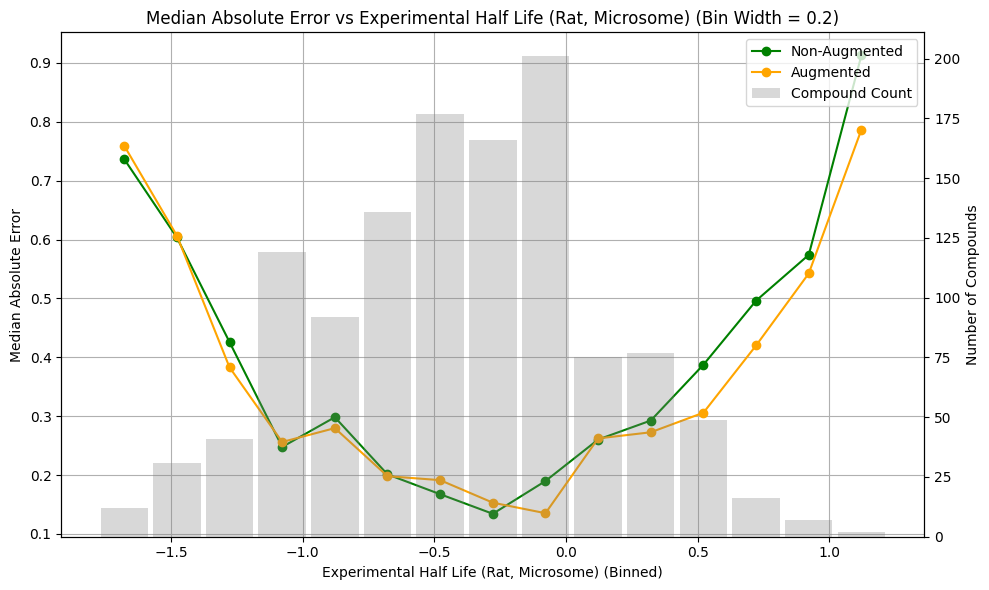

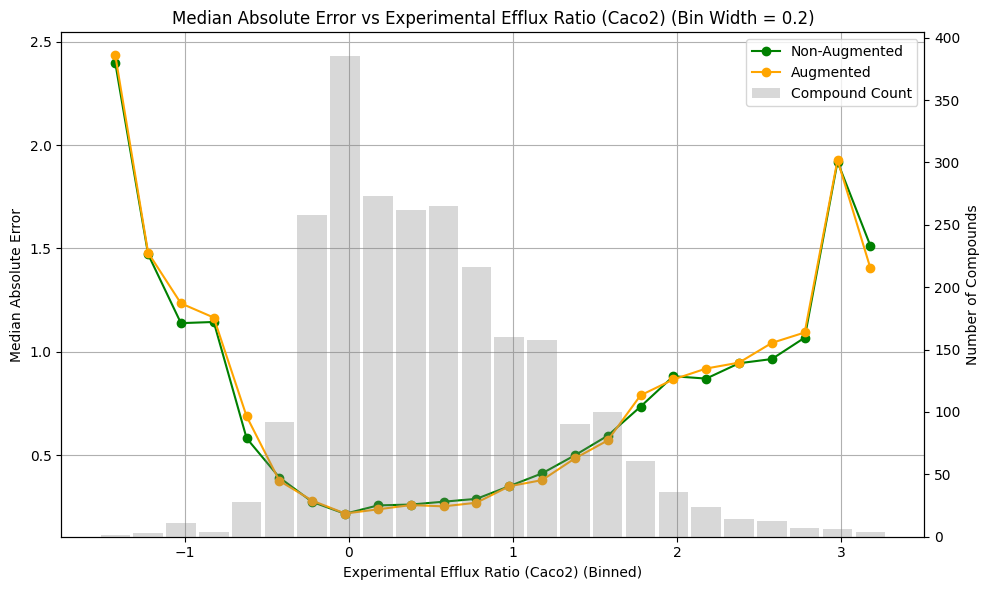

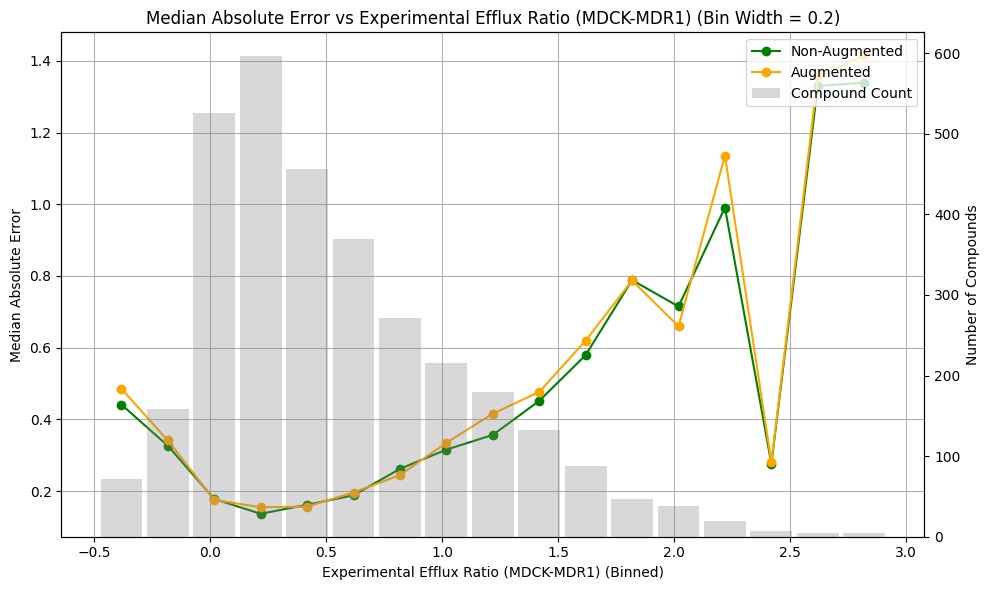

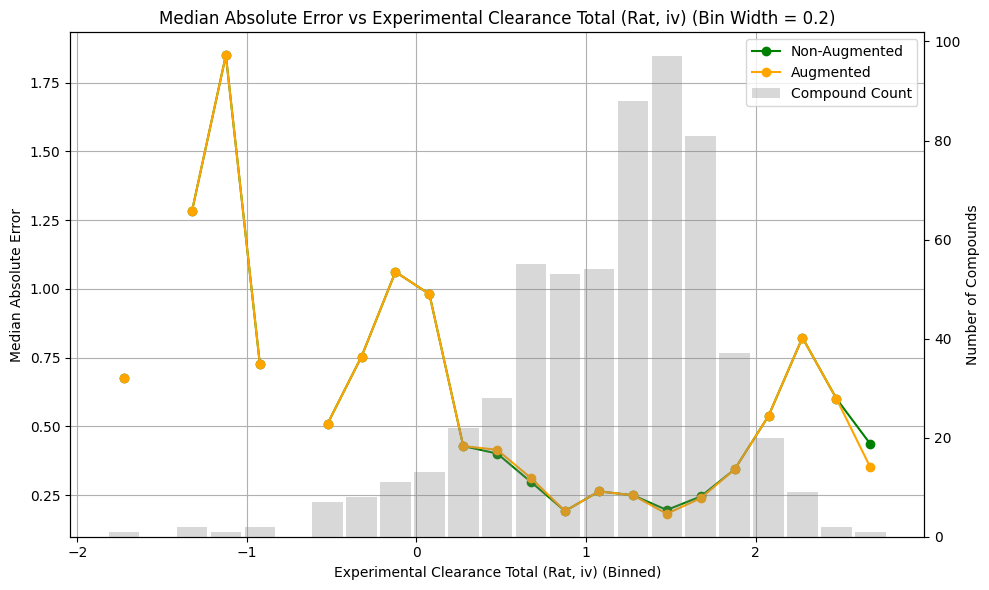

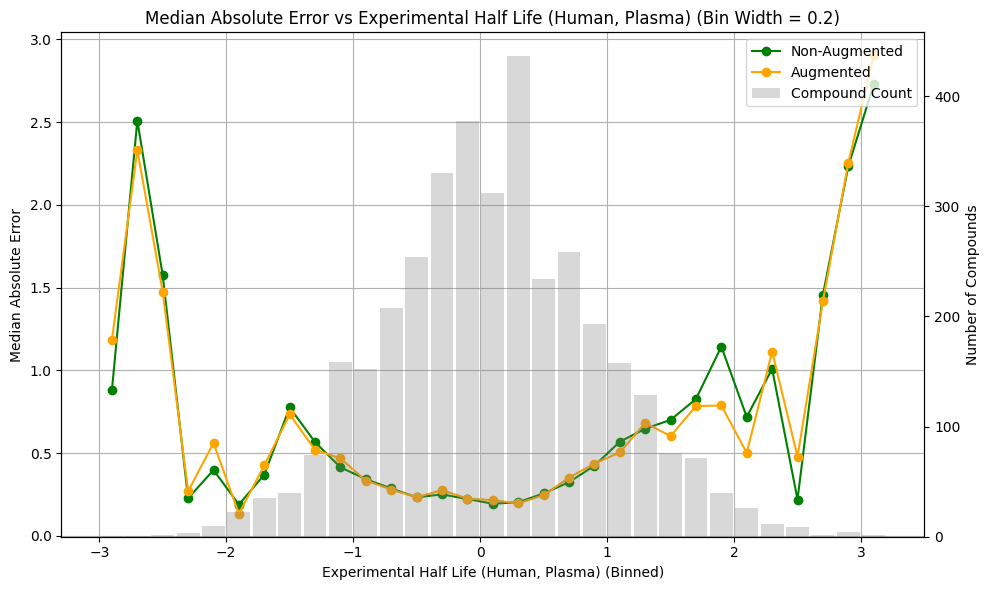

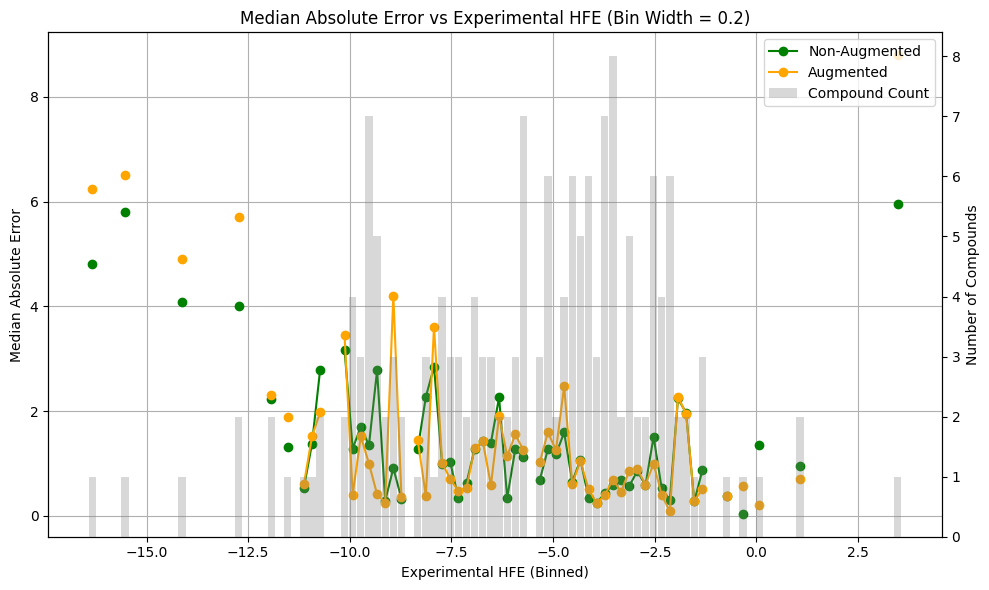

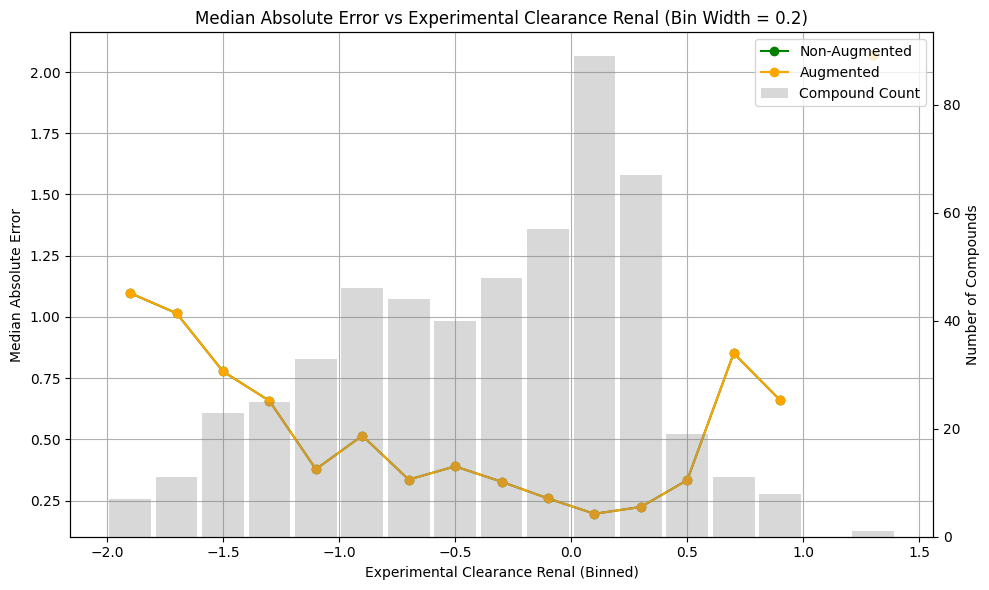

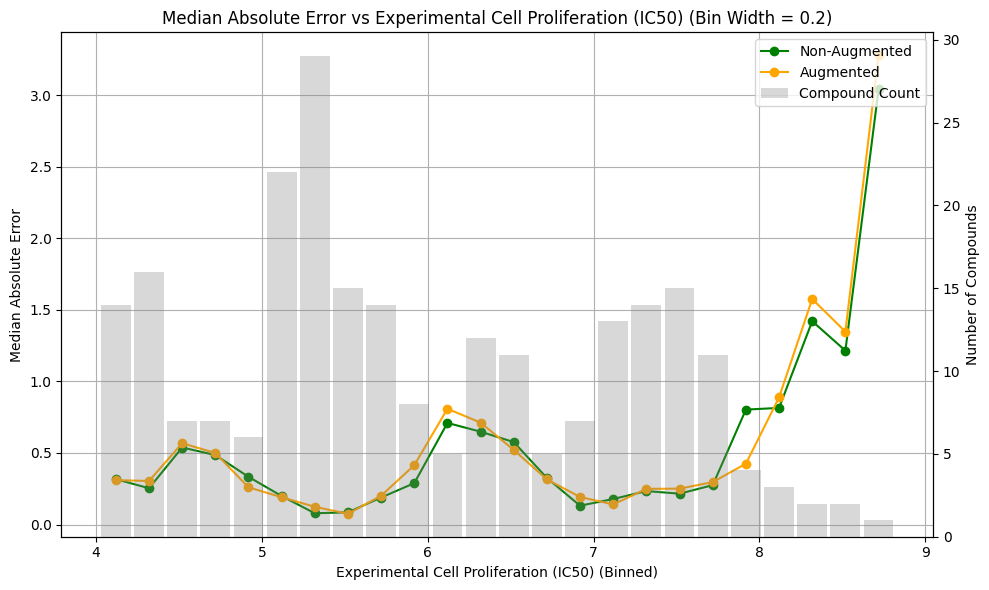

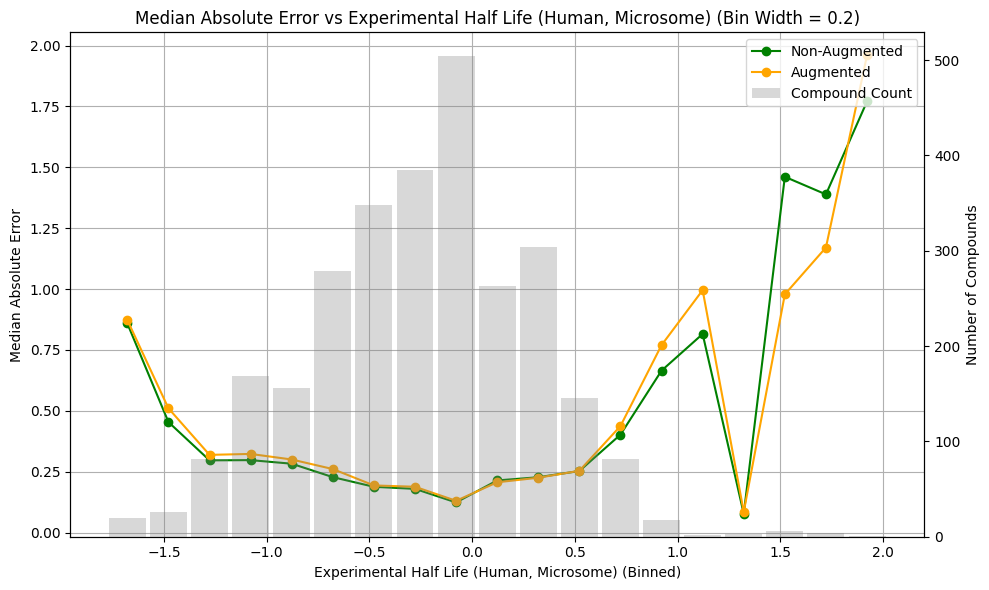

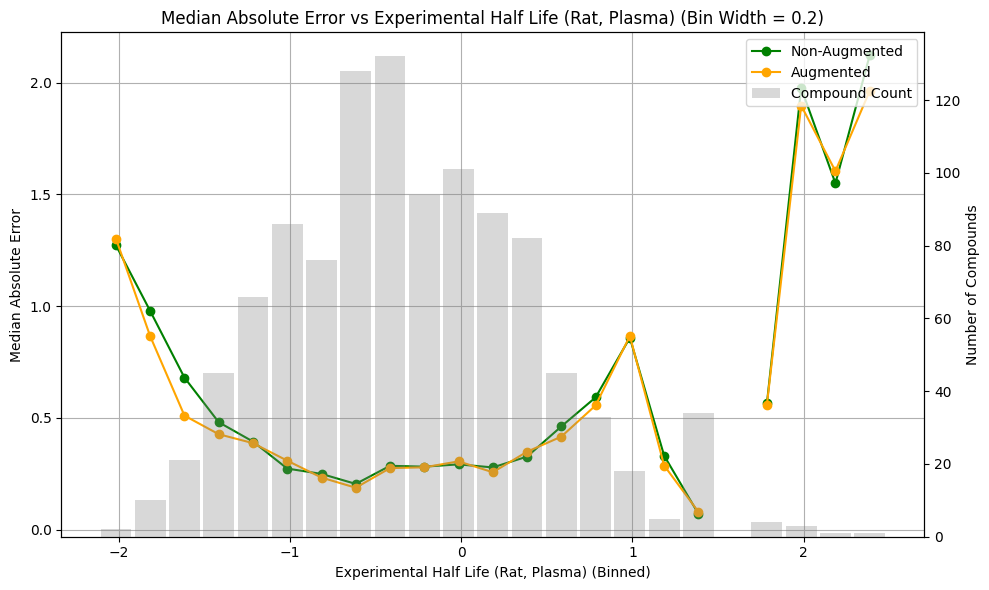

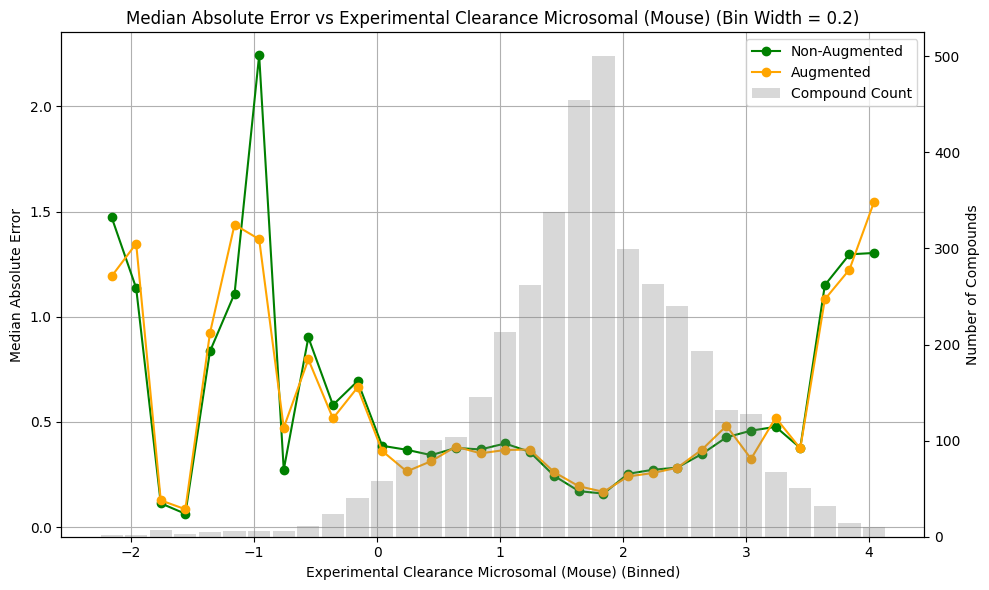

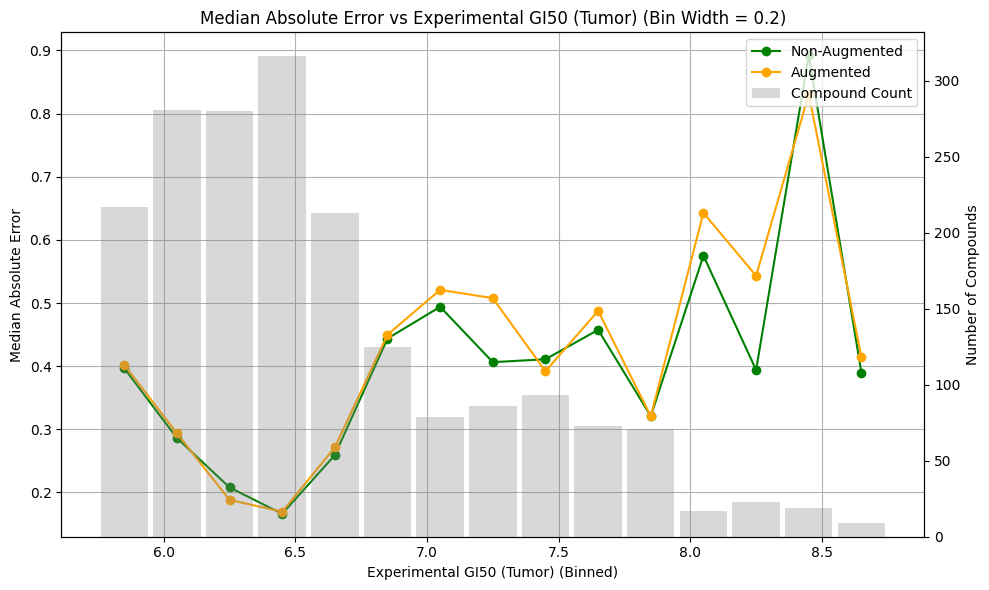

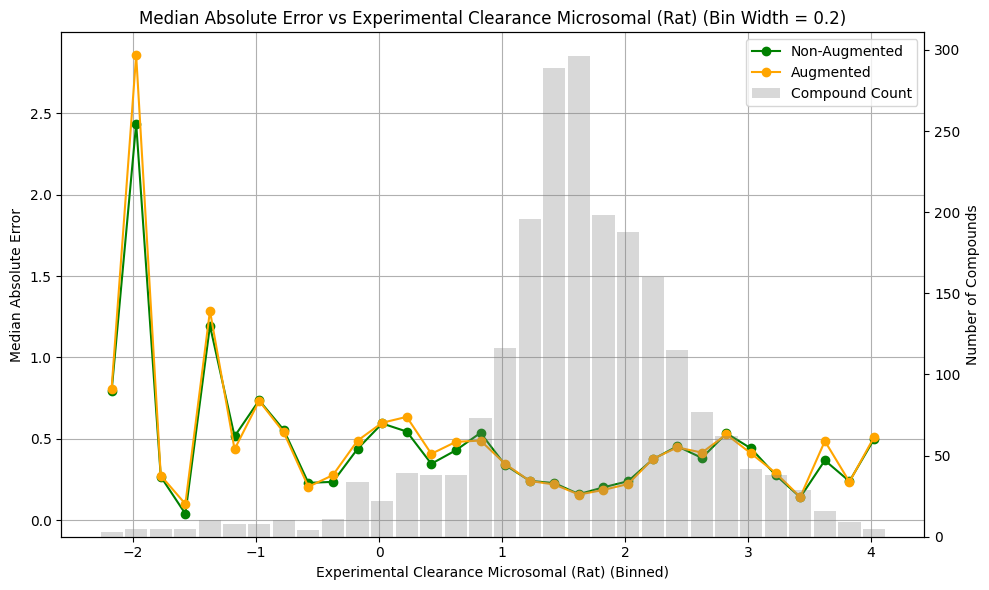

In [18]:
for col_exp in dict_col_to_df:
    if len(os.listdir(f"../data/performance/{exp_col}"))>0:
        df_valid = dict_col_to_df[col_exp]
        plot_mae_vs_experimental_bins(df_valid, col_exp)

In [107]:
# Plot 1: Absolute errors comparison
fig1 = plot_absolute_errors_comparison(df_valid, exp_col)
plt.show()


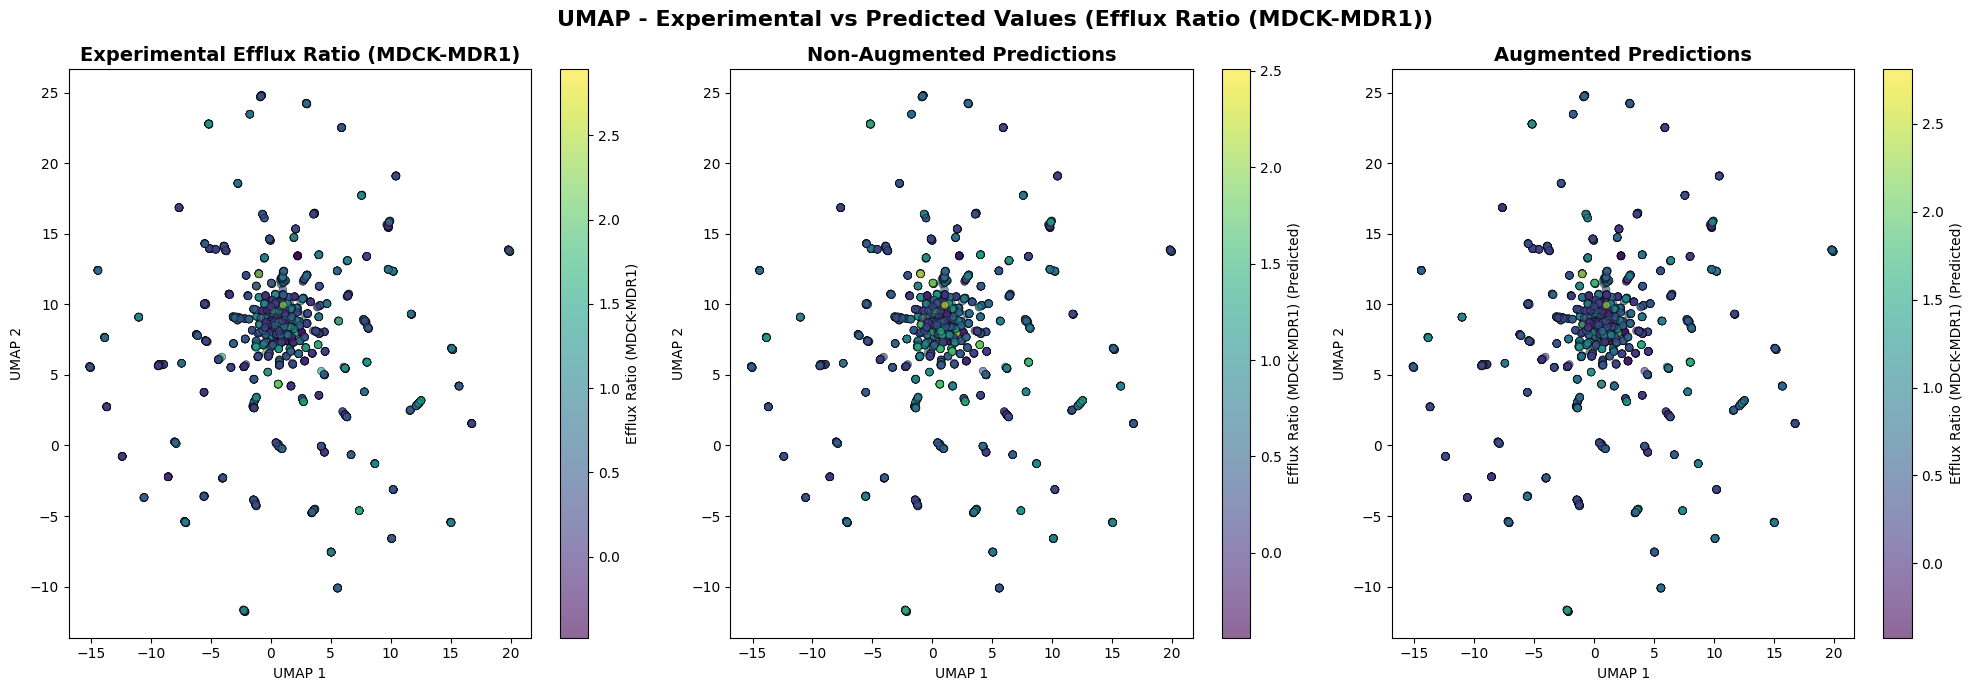

In [108]:
# Plot 2: Predictions comparison with experimental
fig2 = plot_predictions_comparison(df_valid, exp_col)
plt.show()


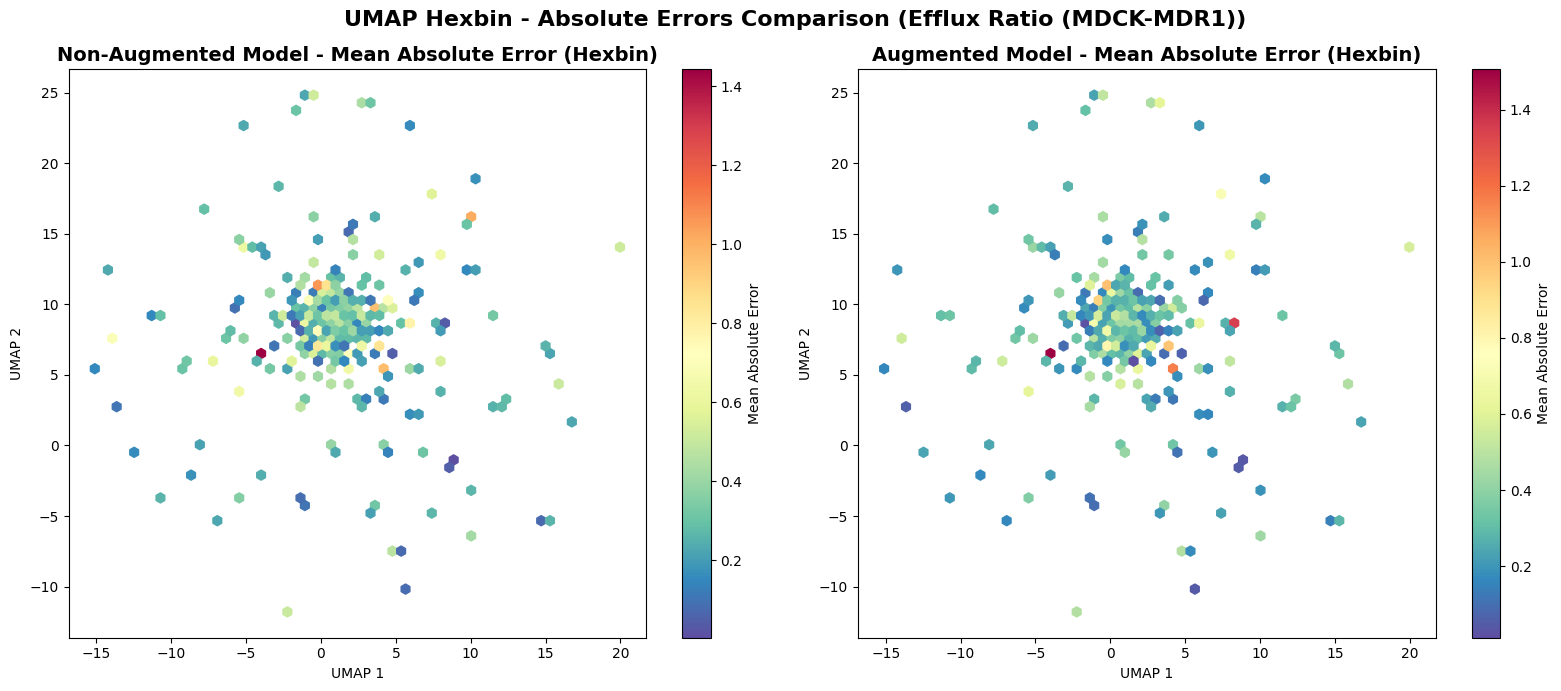

In [109]:
# Plot 3: Hexbin error plots
fig3 = plot_hexbin_errors(df_valid, exp_col)
plt.show()


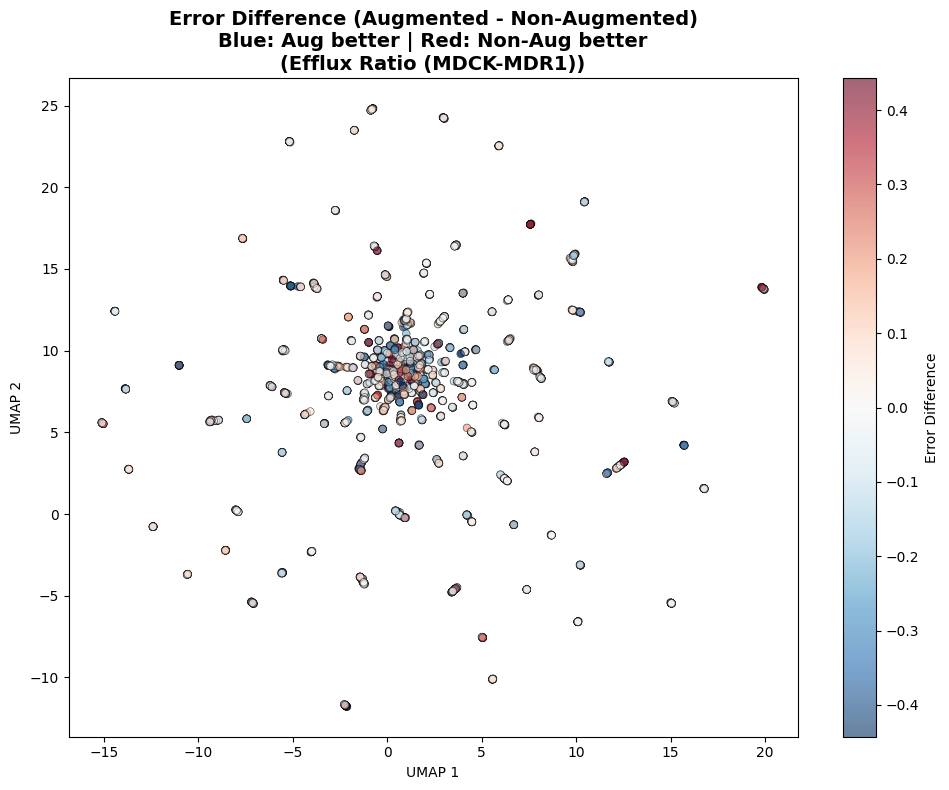

In [110]:
# Plot 4: Error difference
fig4 = plot_error_difference(df_valid, exp_col)
plt.show()


In [111]:
# Step 8: Print statistics
print_statistics(df_valid, exp_col)


COMPREHENSIVE ERROR STATISTICS
Experimental Column: Efflux Ratio (MDCK-MDR1)

--- Non-Augmented Model ---
Valid predictions: 3182
Mean Absolute Error: 0.326
Median Absolute Error: 0.228
Std Dev: 0.325
Min Error: 0.000
Max Error: 2.452

--- Augmented Model ---
Valid predictions: 3182
Mean Absolute Error: 0.332
Median Absolute Error: 0.234
Std Dev: 0.326
Min Error: 0.000
Max Error: 2.395

--- Model Comparison ---
Compounds with both predictions: 3182
Mean Error Difference (Aug - NonAug): 0.005
Compounds where Aug is better: 1567
Compounds where NonAug is better: 1615
Compounds with equal performance: 0
